In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.neighbors import LocalOutlierFactor


In [107]:
from adtk.visualization import plot
from adtk.data import validate_series
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector

In [108]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

In [109]:
m_summ = pd.read_csv('Measurement_summary.csv')
m_summ.head()

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0


In [110]:
m_summ = pd.read_csv('Measurement_summary.csv')
m_summ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647511 entries, 0 to 647510
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Measurement date  647511 non-null  object 
 1   Station code      647511 non-null  int64  
 2   Address           647511 non-null  object 
 3   Latitude          647511 non-null  float64
 4   Longitude         647511 non-null  float64
 5   SO2               647511 non-null  float64
 6   NO2               647511 non-null  float64
 7   O3                647511 non-null  float64
 8   CO                647511 non-null  float64
 9   PM10              647511 non-null  float64
 10  PM2.5             647511 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 54.3+ MB


•	Проверка гипотез: в будние дни загрязненность воздуха ниже чем в выходные

In [111]:
m_summ = pd.read_csv('Measurement_summary.csv')
m_summ = m_summ.drop(['Address', 'Latitude', 'Longitude', 'Station code'], axis=1)

for col in m_summ.columns[1:7]: 
    m_summ[col] = pd.to_numeric(m_summ[col], errors='coerce')
    m_summ.loc[m_summ[col] < 0, col] = 0 


m_summ['Measurement date'] = pd.to_datetime(m_summ['Measurement date'])


m_summ_index = m_summ.set_index('Measurement date')


m_summ_day = m_summ_index[: '2019-12-31'].resample('D').mean()

# Group the data
m_summ_day.reset_index(inplace=True)

m_summ_day['Weekday/Weekend'] = m_summ_day['Measurement date'].dt.dayofweek // 5  # 0 for weekdays, 1 for weekends
grouped_df = m_summ_day.groupby('Weekday/Weekend')

grouped_df.head()

,Measurement date,SO2,NO2,O3,CO,PM10,PM2.5,Weekday/Weekend
0,2017-01-01,0.005293,0.046432,0.004145,0.983500,77.203333,56.775000,1
1,2017-01-02,0.006040,0.039293,0.016460,0.894667,109.246667,77.843333,0
2,2017-01-03,0.005602,0.042017,0.013223,0.762167,78.551667,51.538333,0
3,2017-01-04,0.005788,0.050480,0.008585,0.880167,54.968333,34.535000,0
4,2017-01-05,0.004788,0.035558,0.011392,0.658000,36.248333,22.170000,0
5,2017-01-06,0.004458,0.035027,0.012730,0.530500,21.076667,13.256667,0
6,2017-01-07,0.005022,0.049277,0.004617,0.877667,53.938333,37.176667,1
7,2017-01-08,0.004412,0.031923,0.015080,0.589833,31.160000,21.726667,1
13,2017-01-14,0.003950,0.012817,0.023657,0.418833,43.903333,11.641667,1
14,2017-01-15,0.003973,0.021718,0.016118,1.079333,27.045000,13.593333,1


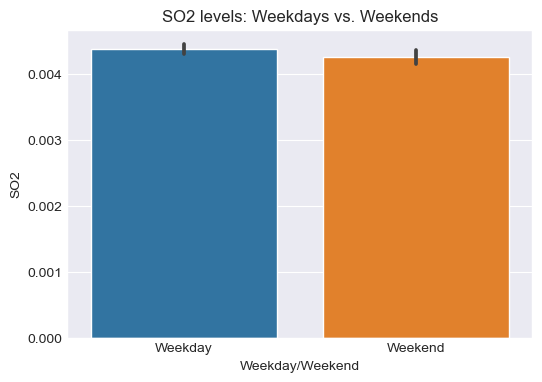

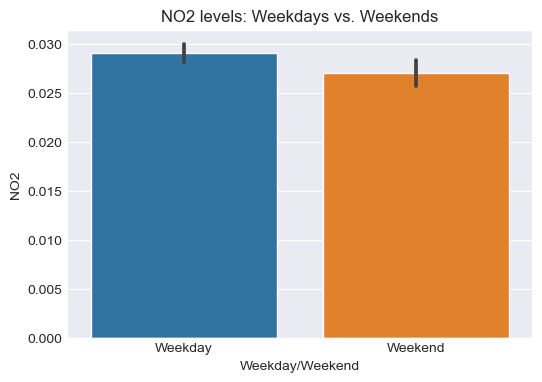

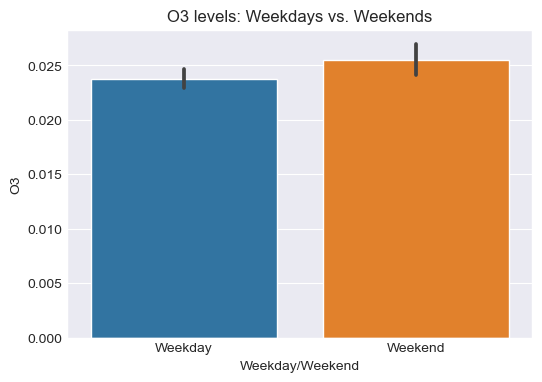

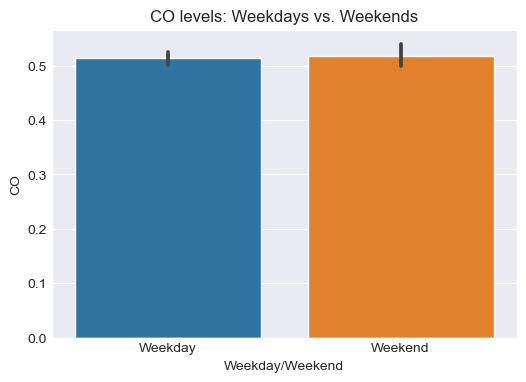

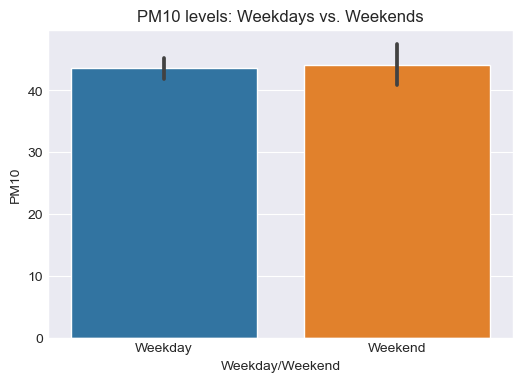

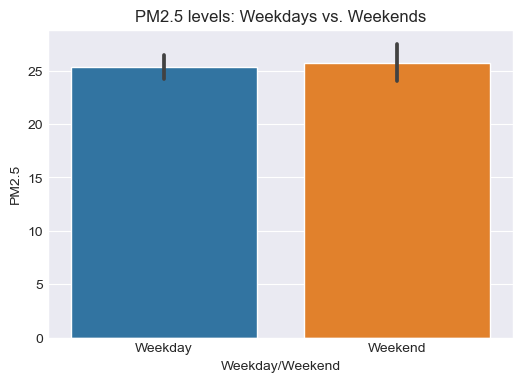

In [112]:
elements = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']
sns.set_style("darkgrid")

for element in elements:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=m_summ_day, x='Weekday/Weekend', y=element)
    plt.xlabel('Weekday/Weekend')
    plt.ylabel(element)
    plt.title(f'{element} levels: Weekdays vs. Weekends')
    plt.xticks([0, 1], ['Weekday', 'Weekend'])
    plt.show()


In [113]:
m_summ = pd.read_csv('Measurement_summary.csv')

m_summ['Measurement date'] = pd.to_datetime(m_summ['Measurement date'])
m_summ['Weekday/Weekend'] = m_summ['Measurement date'].dt.dayofweek // 5 
m_summ['Year'] = m_summ['Measurement date'].dt.year

grouped_data = m_summ.groupby(['Year', 'Weekday/Weekend']).mean()

for element in elements:
    print(f"Среднее значение {element}")
    print(grouped_data[element], '\n')


Среднее значение SO2
Year  Weekday/Weekend
2017  0                  0.003271
      1                  0.003042
2018  0                 -0.001244
      1                 -0.000728
2019  0                 -0.007573
      1                 -0.008212
Name: SO2, dtype: float64 

Среднее значение NO2
Year  Weekday/Weekend
2017  0                  0.028445
      1                  0.026448
2018  0                  0.023715
      1                  0.022984
2019  0                  0.016559
      1                  0.014159
Name: NO2, dtype: float64 

Среднее значение O3
Year  Weekday/Weekend
2017  0                  0.022856
      1                  0.023719
2018  0                  0.017085
      1                  0.020638
2019  0                  0.011992
      1                  0.013810
Name: O3, dtype: float64 

Среднее значение CO
Year  Weekday/Weekend
2017  0                  0.512895
      1                  0.530170
2018  0                  0.494409
      1                  0.494958

/var/folders/9x/d3dvqy2x2fd3gntsc3m2t23c0000gn/T/ipykernel_58312/277222072.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = m_summ.groupby(['Year', 'Weekday/Weekend']).mean()


•	Прогностическое моделирование: можем ли мы предсказать  концентрацию газов на основе сезонных явлении

In [114]:
m_summ = pd.read_csv('Measurement_summary.csv')
m_summ = m_summ.drop(['Address', 'Latitude', 'Longitude', 'Station code'], axis=1)

# Loop through columns and replace negative values with zero
for col in m_summ.columns[1:7]:  # Adjust the column range as per your data
    m_summ[col] = pd.to_numeric(m_summ[col], errors='coerce')  # Convert column to numeric type
    m_summ.loc[m_summ[col] < 0, col] = 0  # Replace negative values with zero


m_summ['Measurement date'] = pd.to_datetime(m_summ['Measurement date'])
m_summ_index = m_summ.set_index('Measurement date')

m_summ_month = m_summ_index[: '2019-12-31'].resample('M').mean()
m_summ_month.head()


,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,
2017-01-31,0.005012,0.034788,0.014110,0.702651,52.752366,32.526935
2017-02-28,0.005055,0.034625,0.018249,0.634208,45.703214,28.546905
2017-03-31,0.005140,0.037669,0.024718,0.591720,59.455914,39.612527
2017-04-30,0.004966,0.031194,0.034605,0.504556,55.906278,26.234111
2017-05-31,0.005183,0.028162,0.038675,0.431543,62.747097,24.312634


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

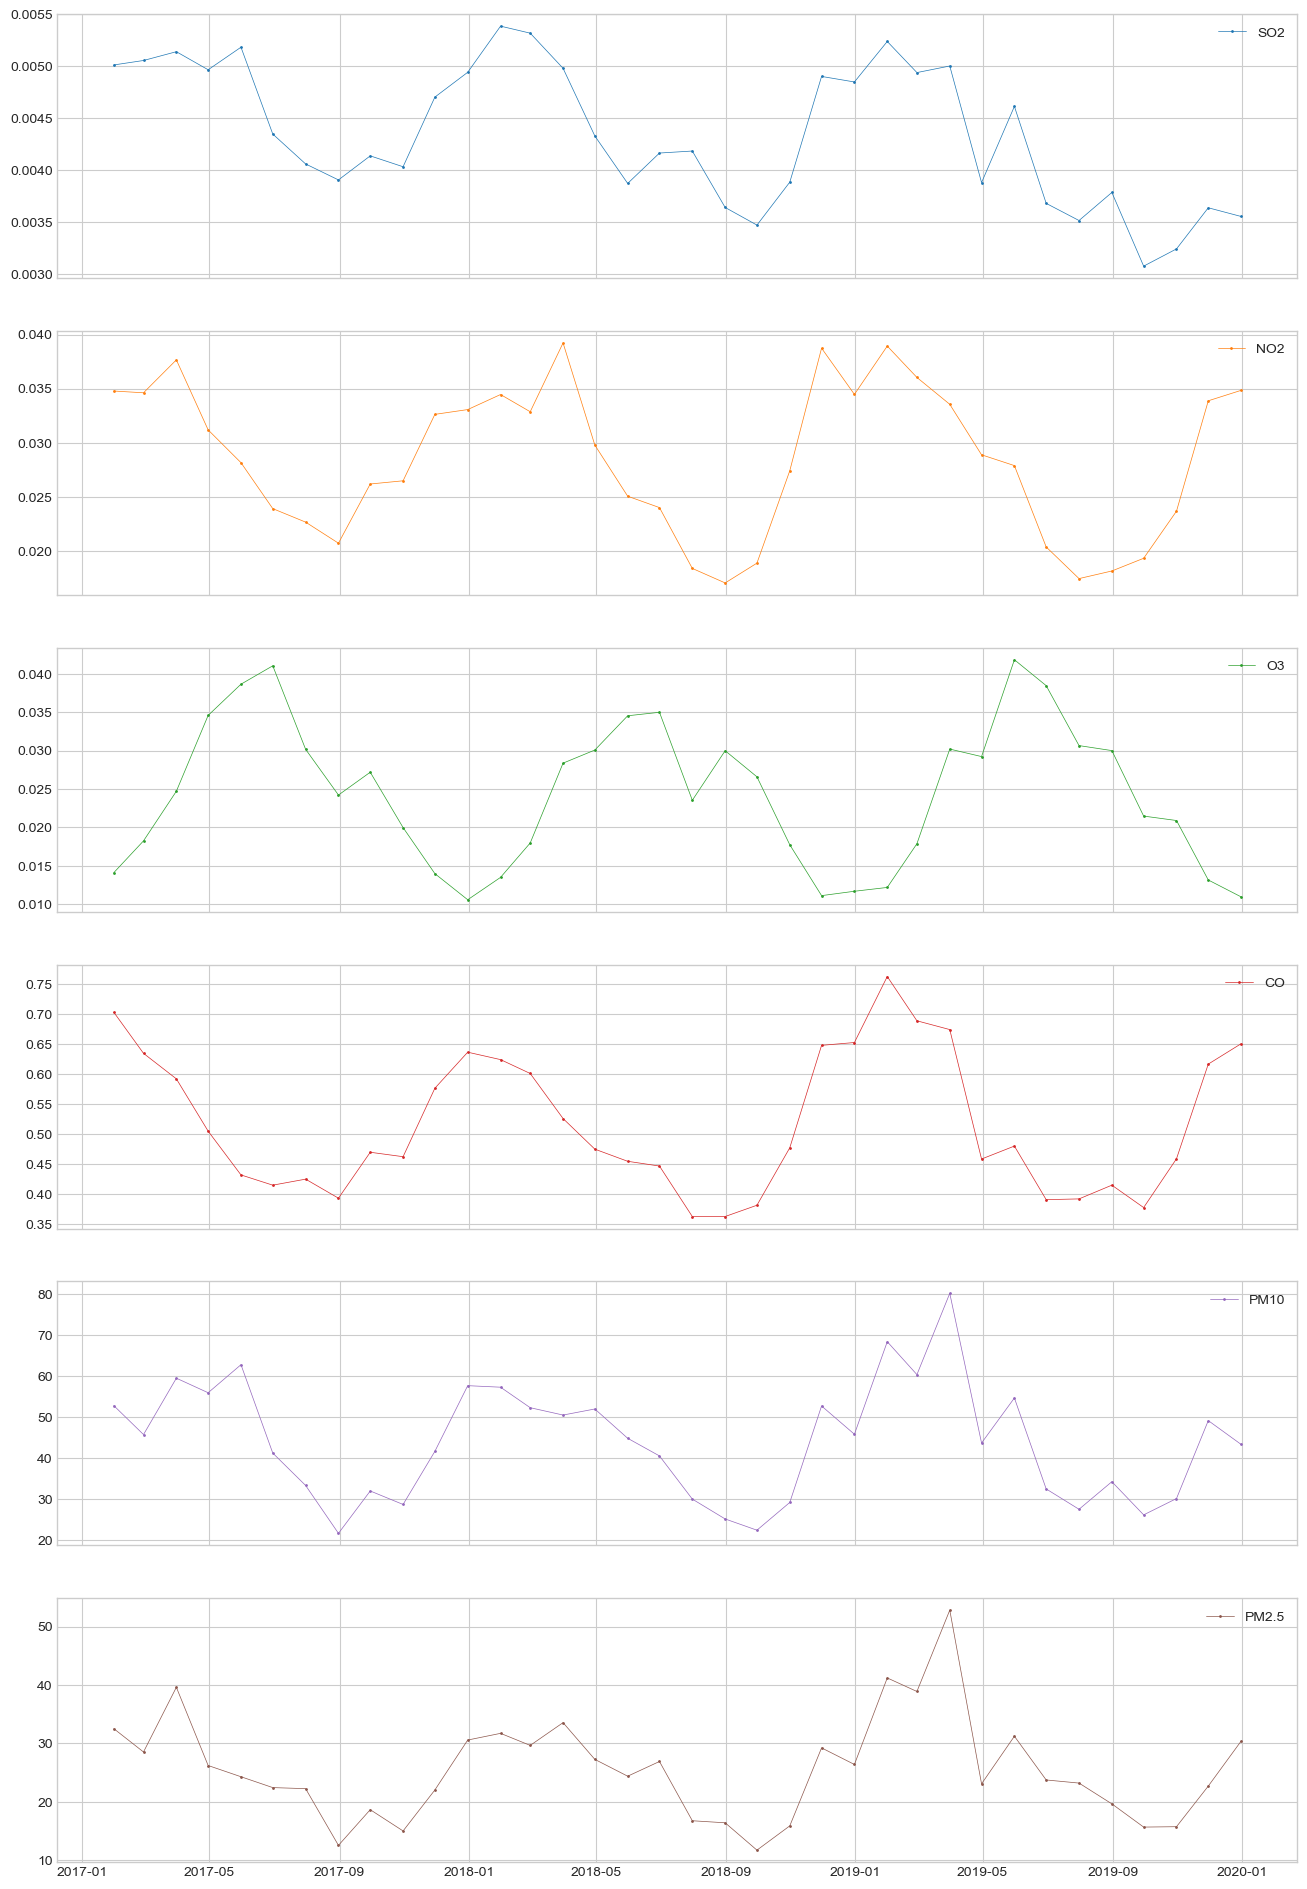

In [115]:
m_summ_s=validate_series(m_summ_month)
plot(m_summ_s)

array([[<Axes: title={'center': 'SO2'}>, <Axes: title={'center': 'NO2'}>],
       [<Axes: title={'center': 'O3'}>, <Axes: title={'center': 'CO'}>],
       [<Axes: title={'center': 'PM10'}>,
        <Axes: title={'center': 'PM2.5'}>]], dtype=object)

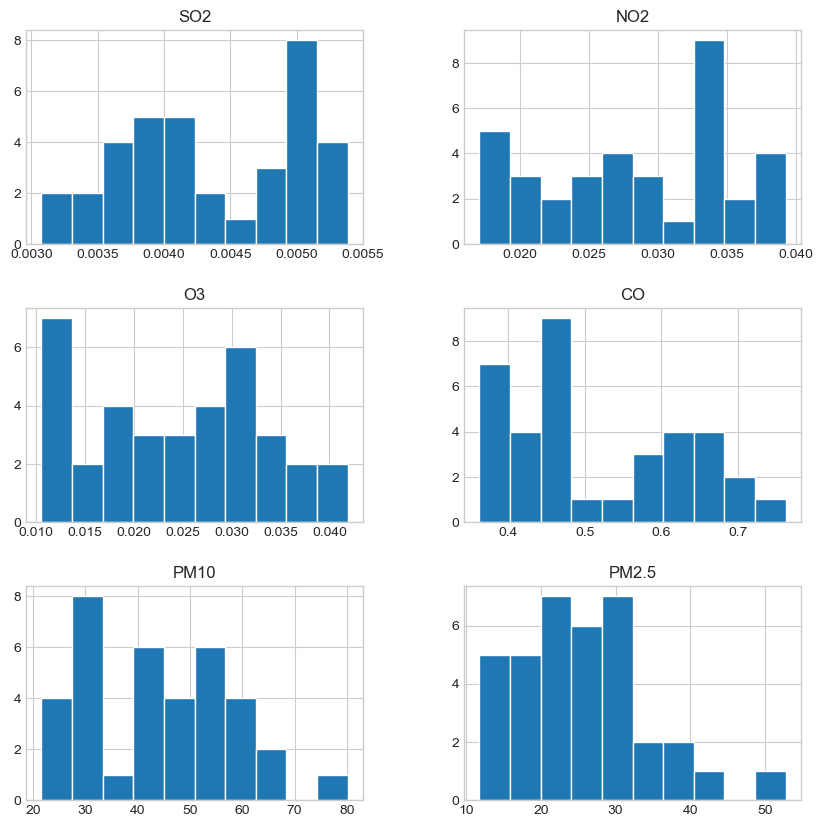

In [116]:
m_summ_s.hist()

In [137]:
m_SO2_summ = m_summ_s.drop(['NO2', 'O3', 'CO', 'PM10', 'PM2.5'], axis=1)
m_NO2_summ = m_summ_s.drop(['SO2', 'O3', 'CO', 'PM10', 'PM2.5' ], axis=1)
m_O3_summ = m_summ_s.drop(['SO2', 'NO2', 'CO', 'PM10', 'PM2.5'], axis=1)
m_CO_summ = m_summ_s.drop(['SO2', 'NO2', 'O3', 'PM10', 'PM2.5'], axis=1)
m_PM10_summ = m_summ_s.drop(['SO2', 'NO2', 'O3', 'CO', 'PM2.5'], axis=1)
m_PM2_5_summ = m_summ_s.drop(['SO2', 'NO2', 'O3', 'CO', 'PM10'], axis=1)

[<Axes: >]

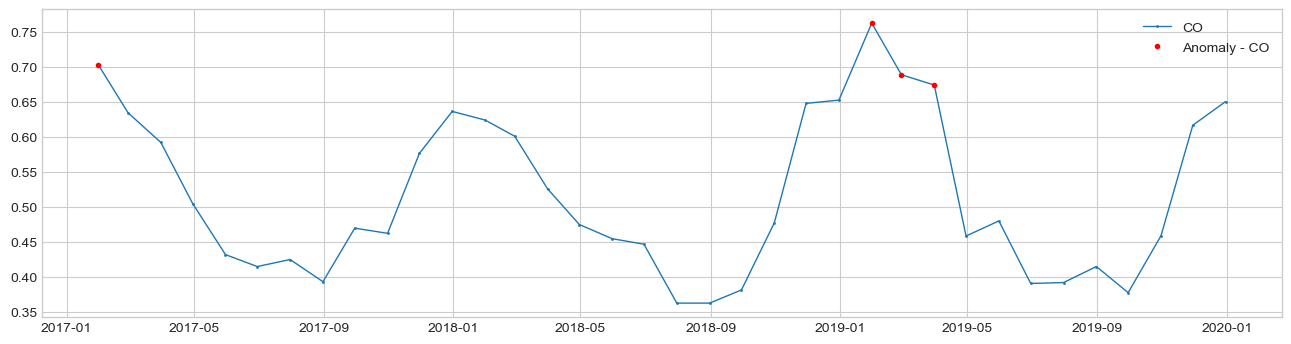

In [118]:
threshold = ThresholdAD(high=0.67, low=0.20)
anomalies_CO = threshold.detect(m_CO_summ)
plot(m_CO_summ, anomaly=anomalies_CO, ts_linewidth=1, anomaly_markersize=3, anomaly_color='red', anomaly_tag='marker')

In [119]:
anomalies_CO[anomalies_CO.CO]

,CO
Measurement date,
2017-01-31,True
2019-01-31,True
2019-02-28,True
2019-03-31,True


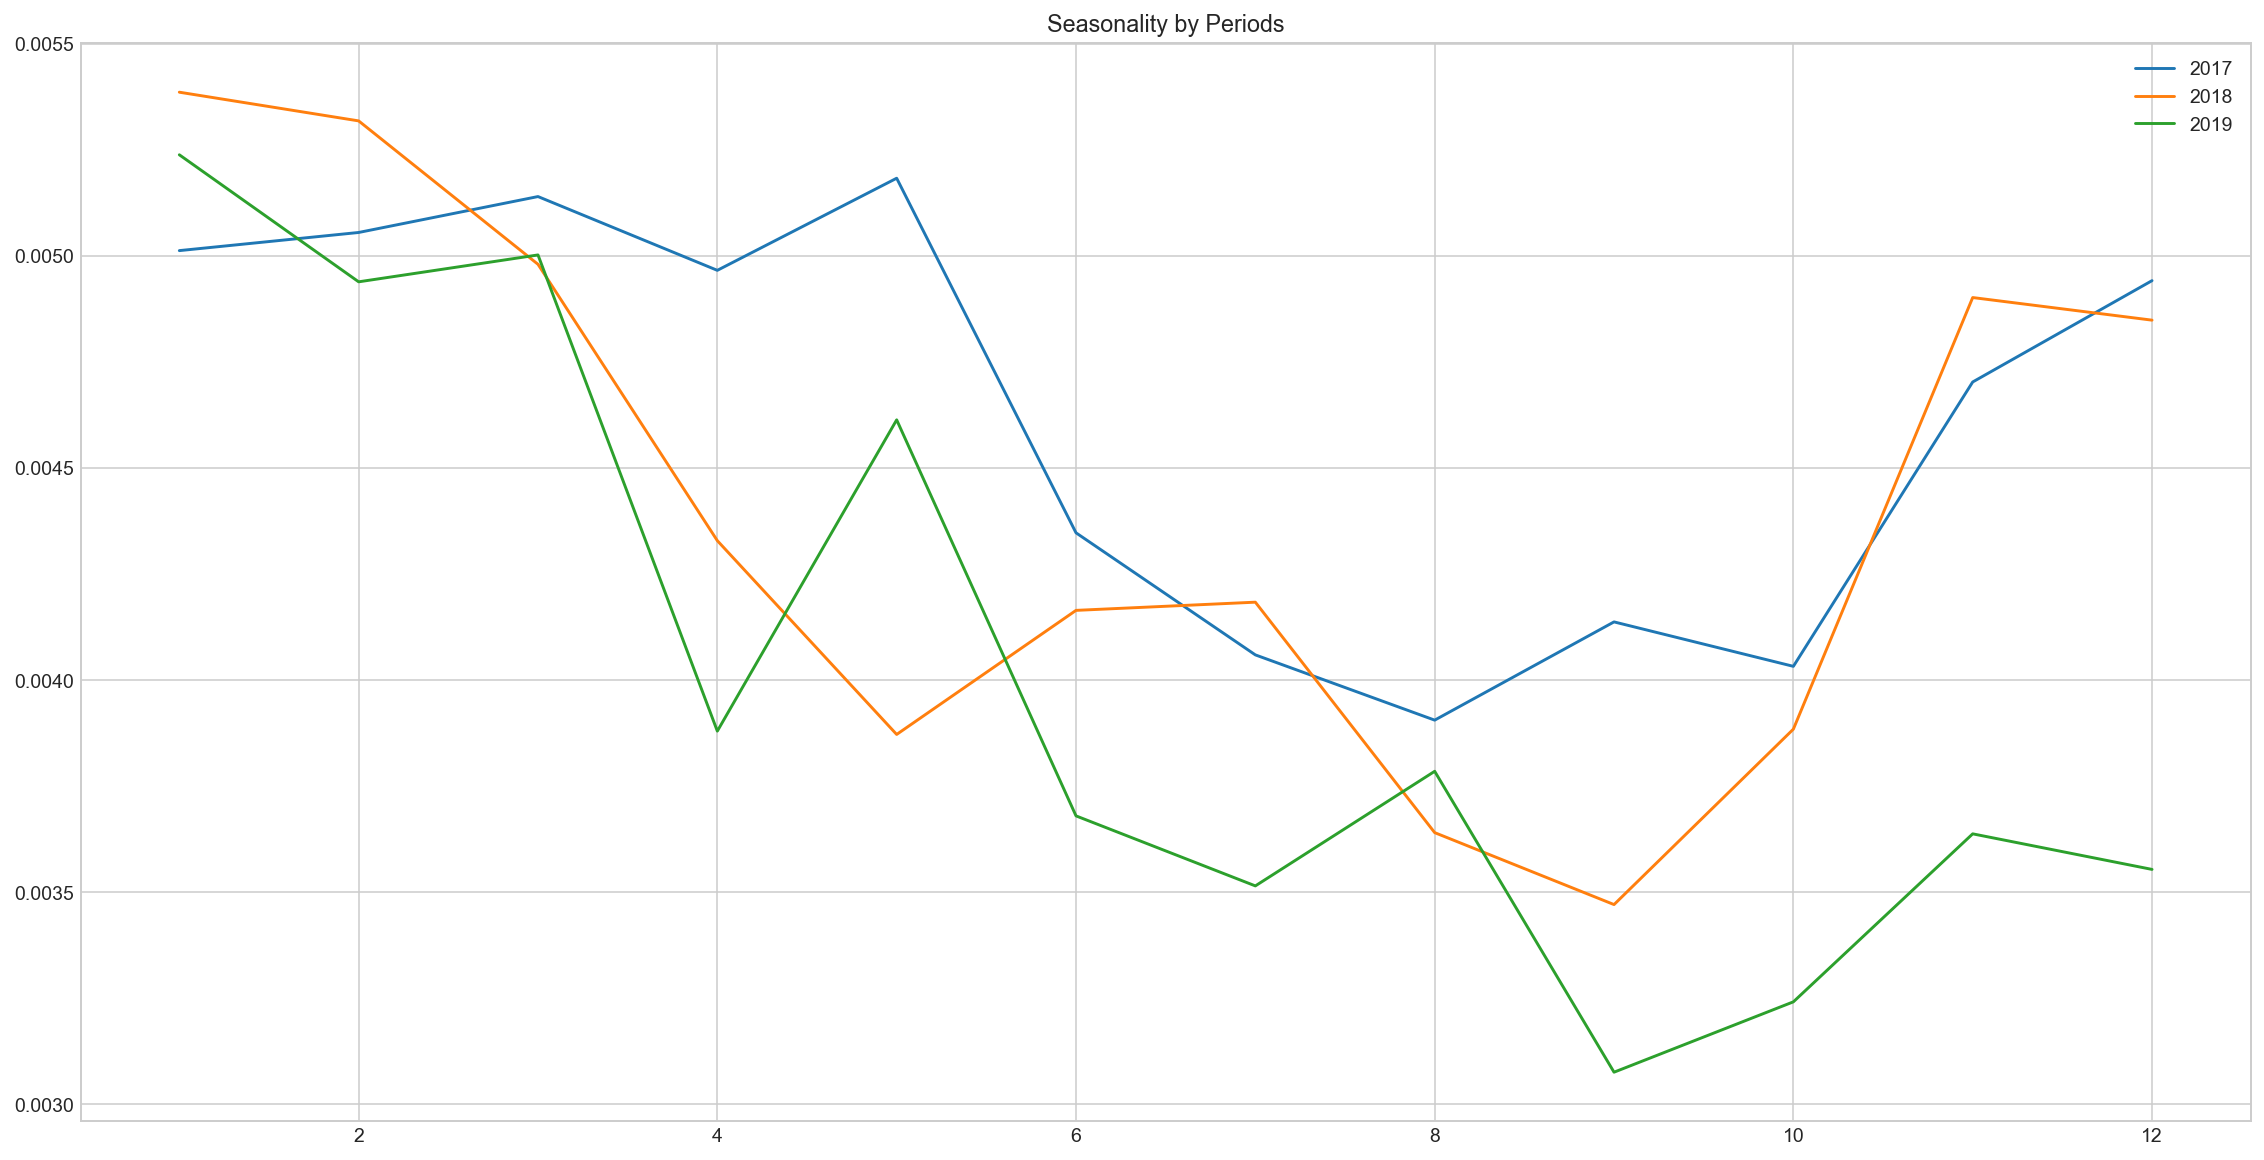

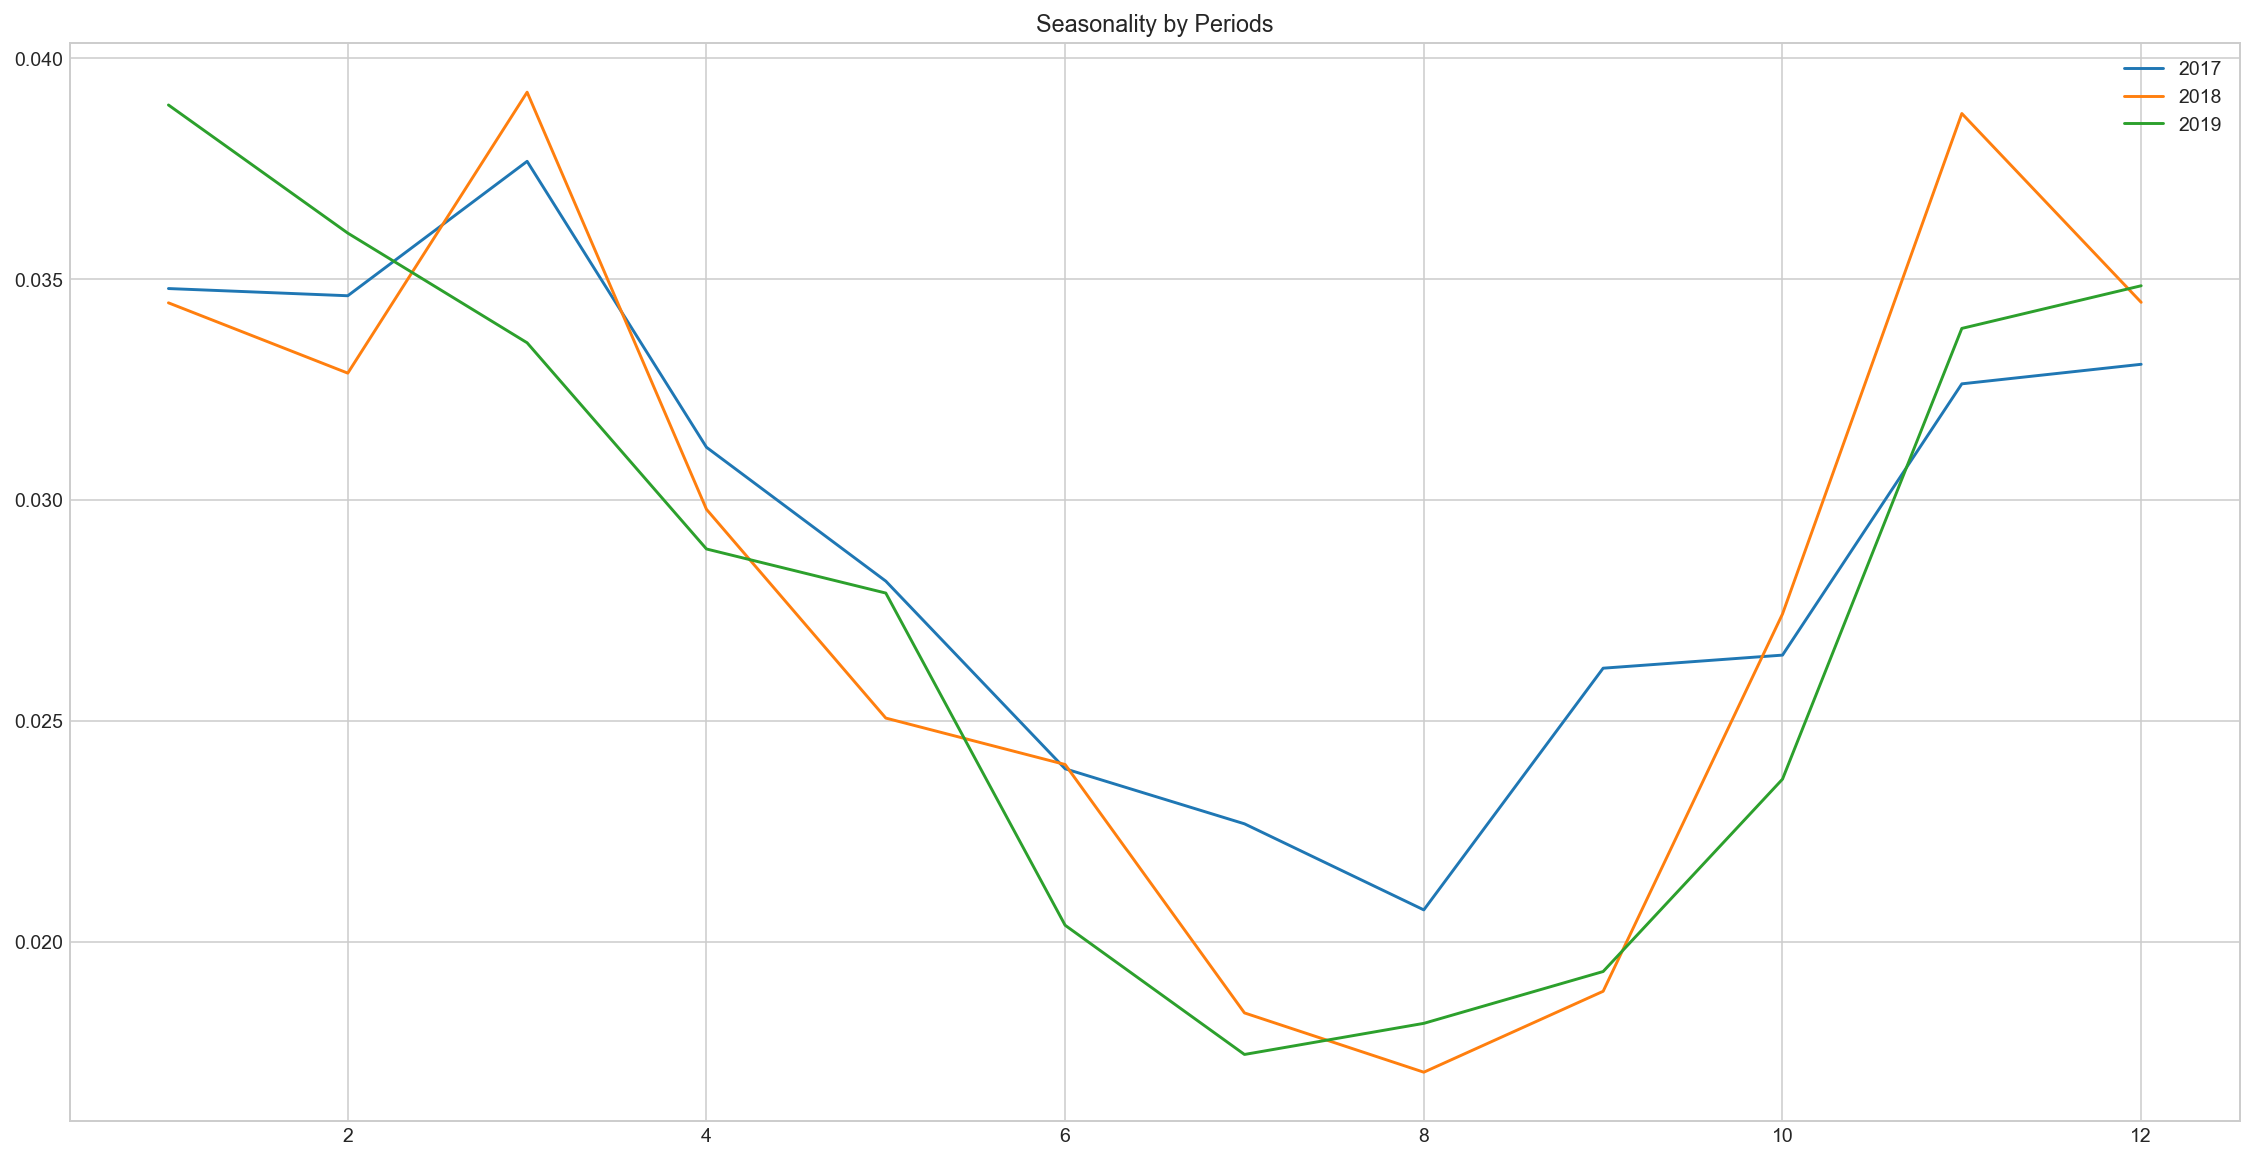

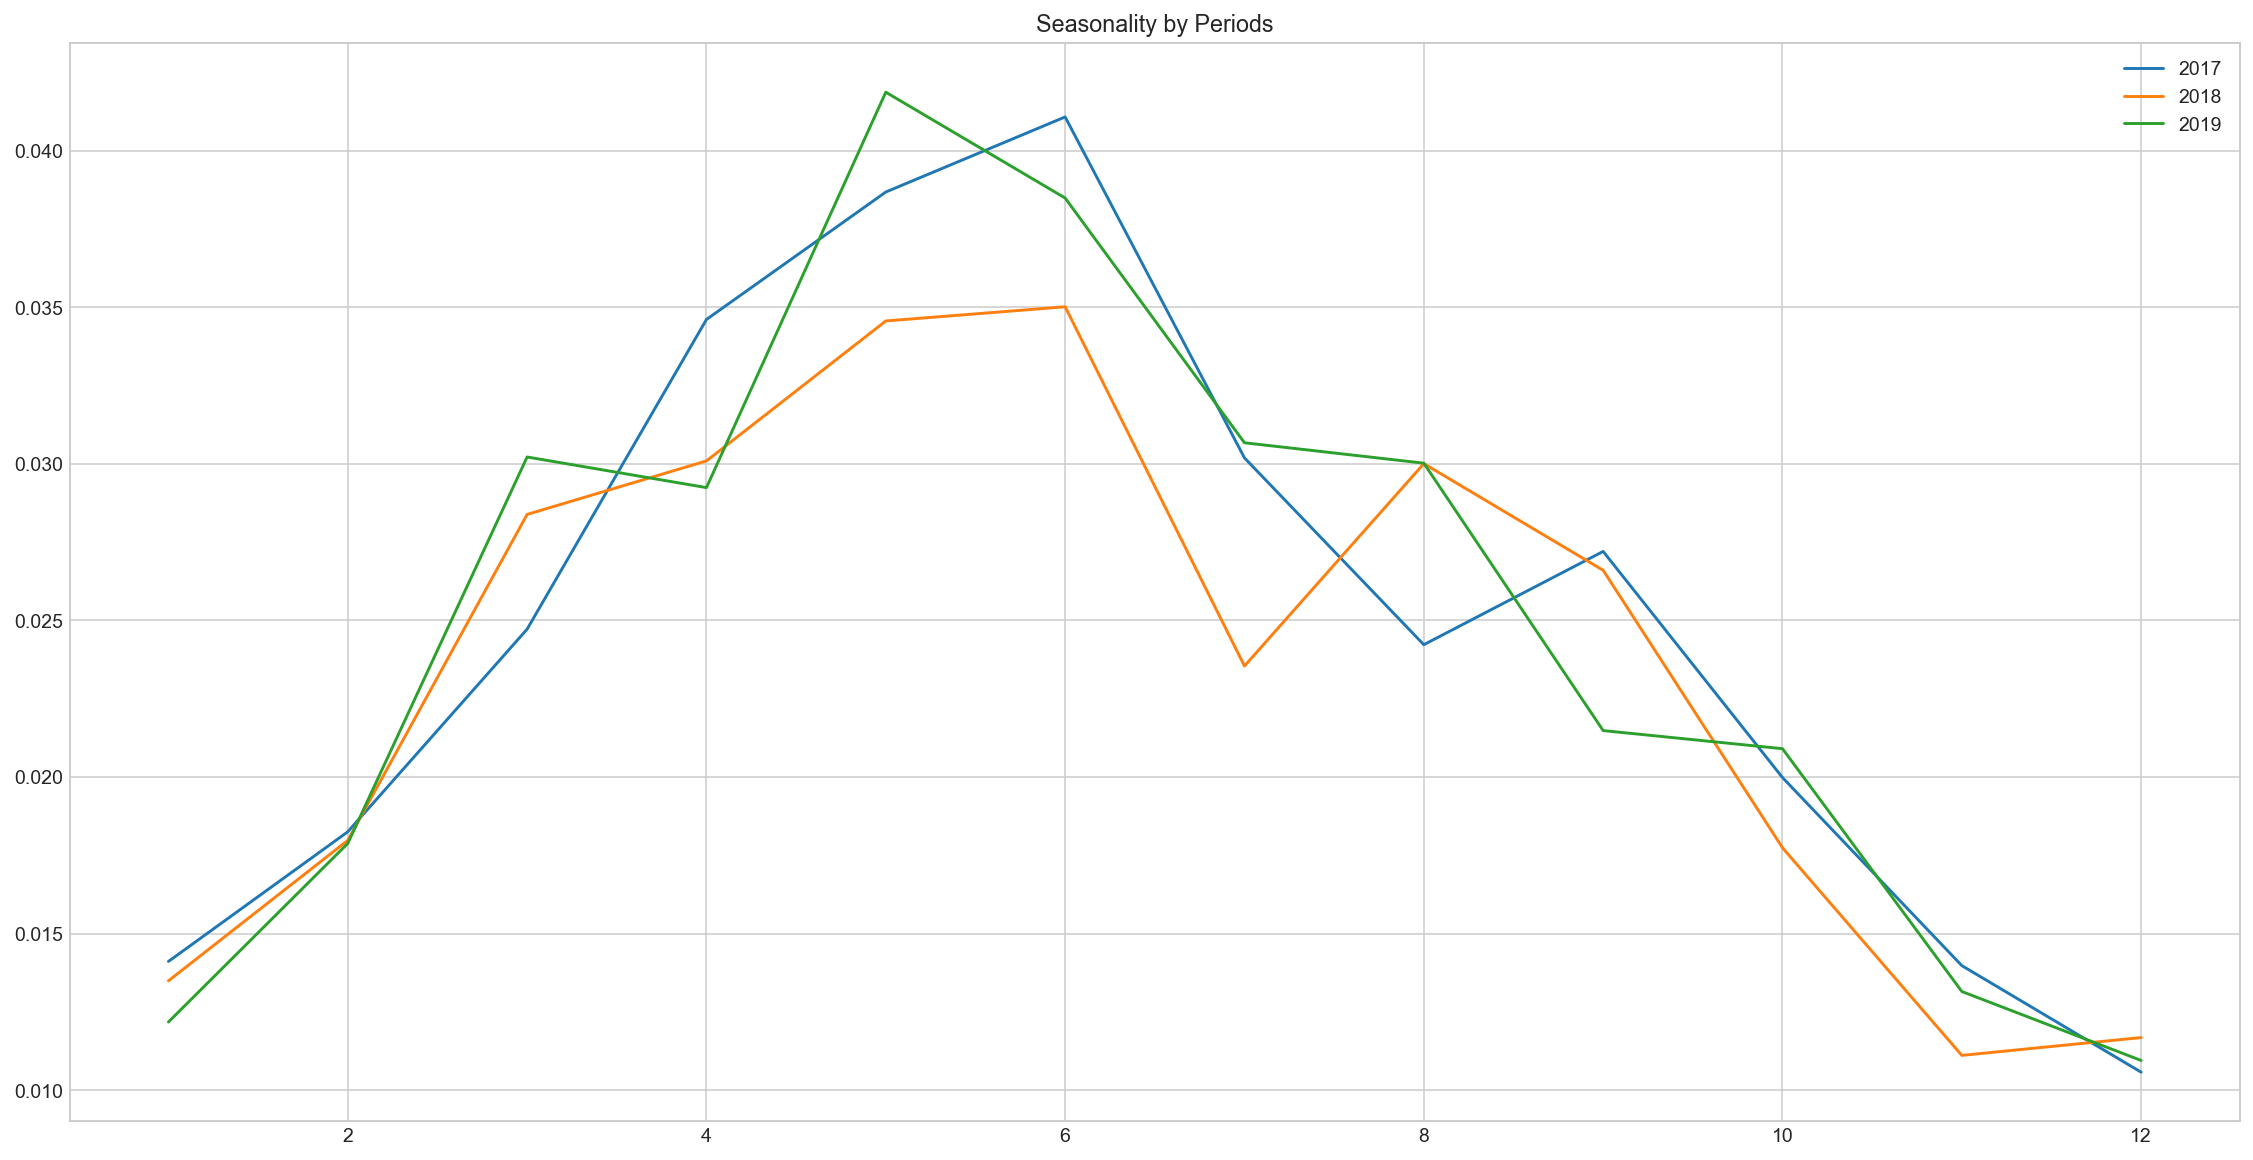

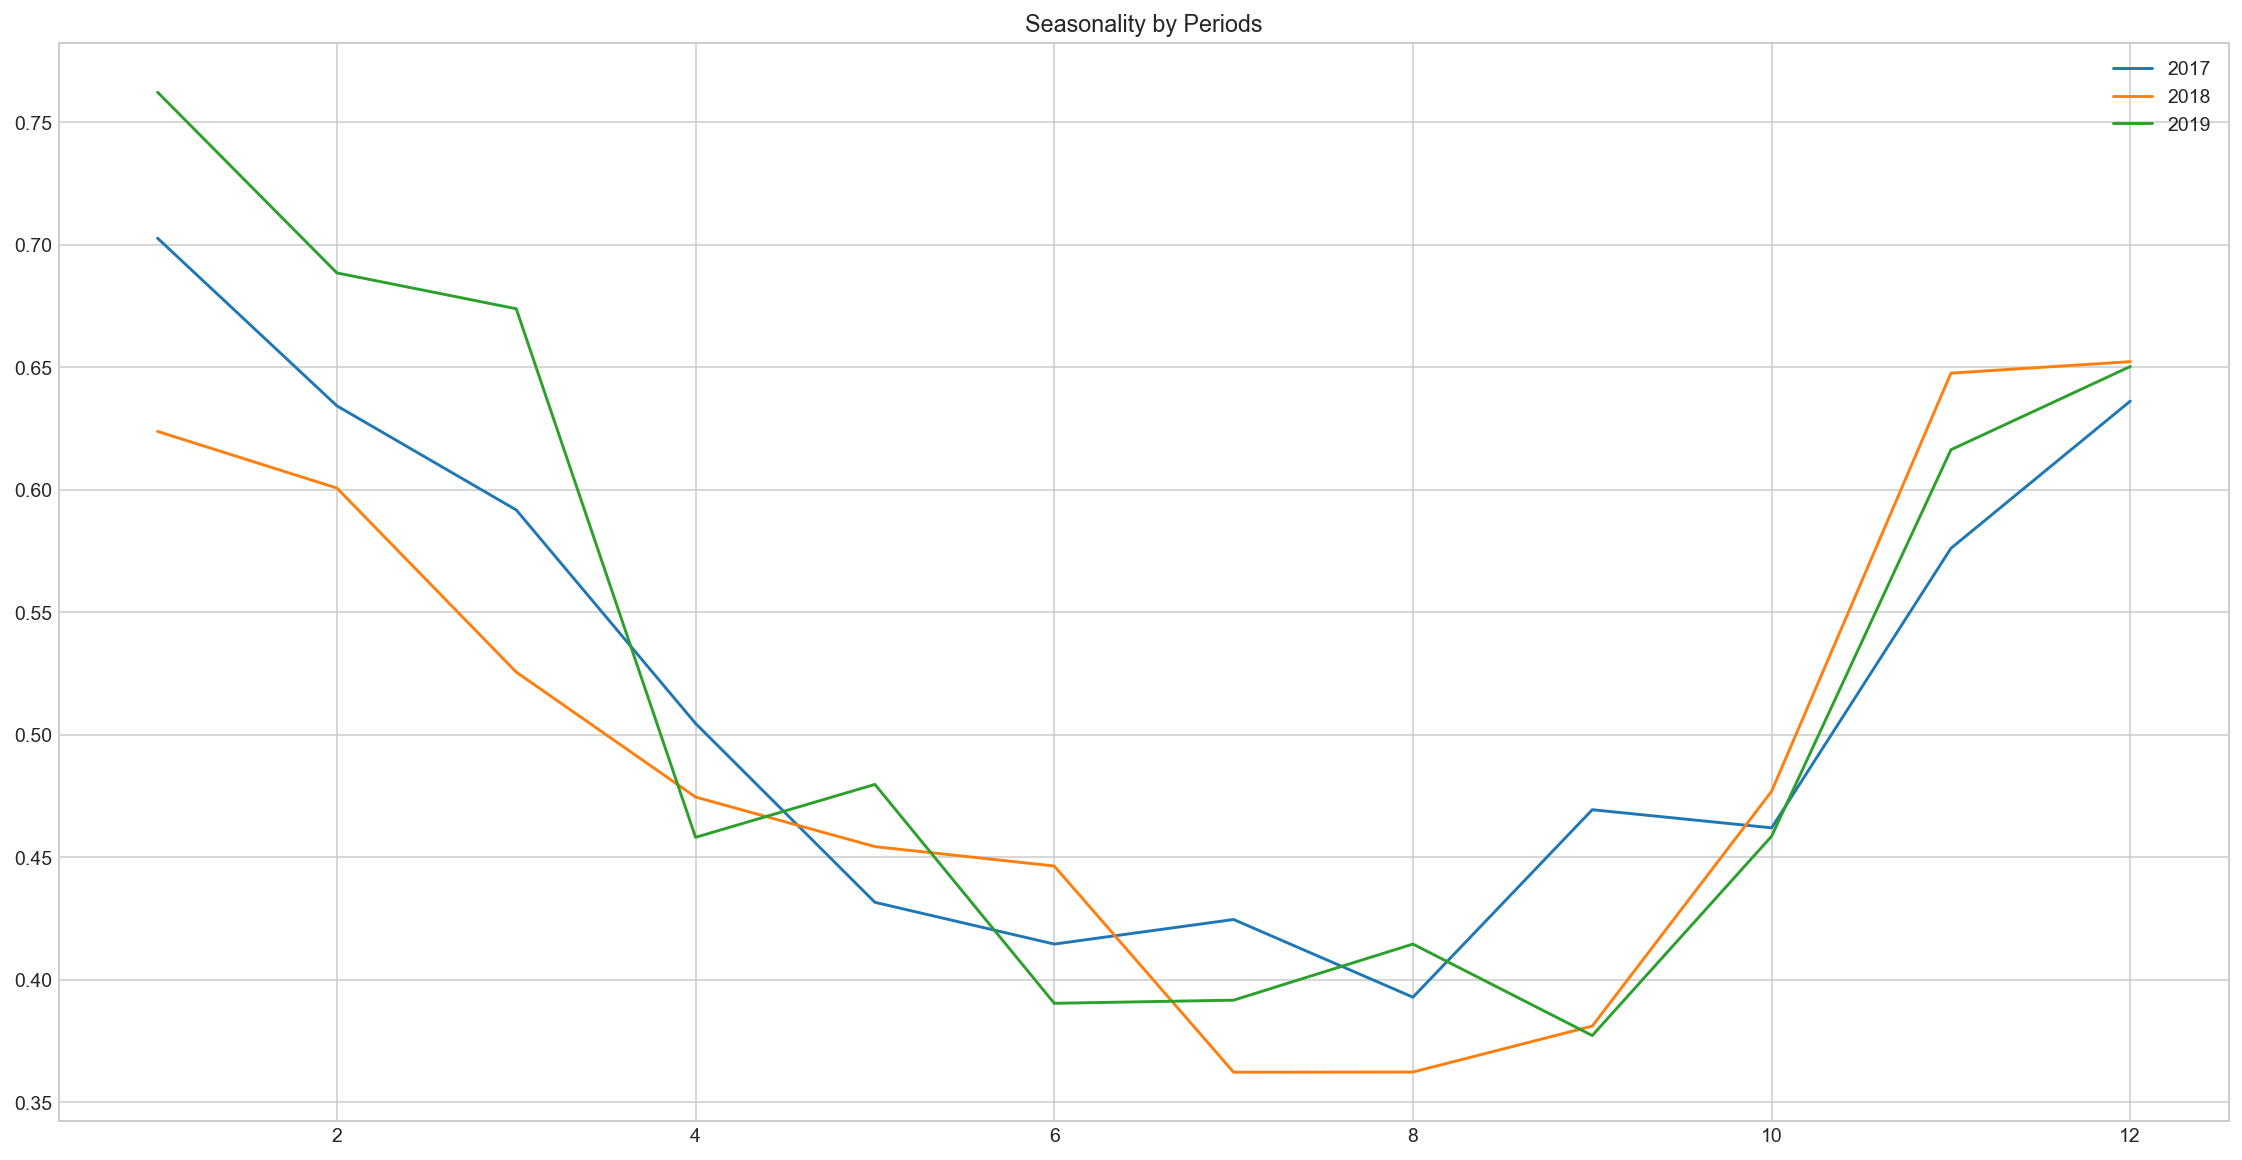

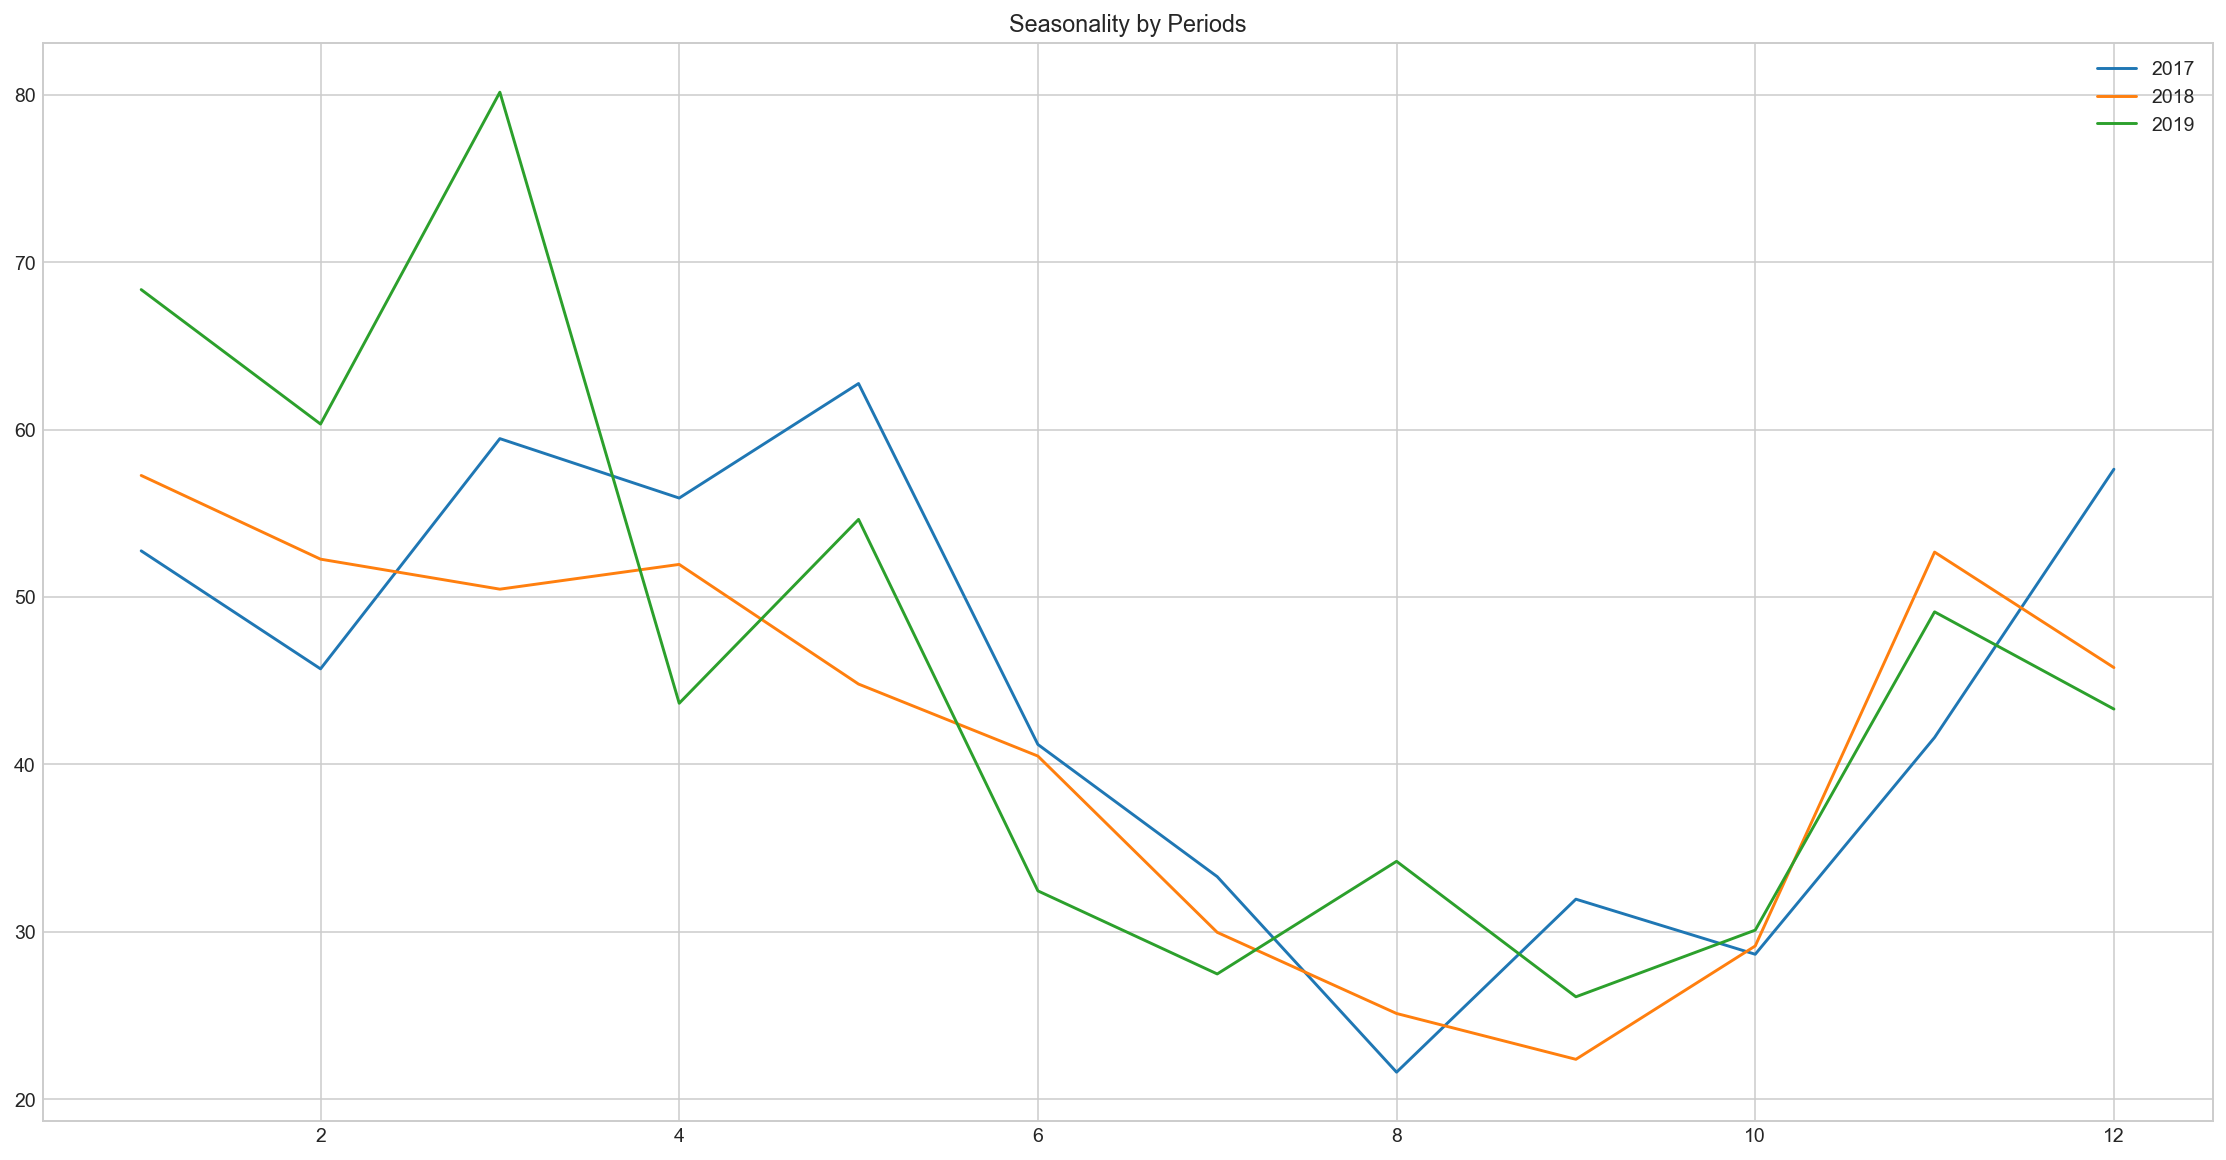

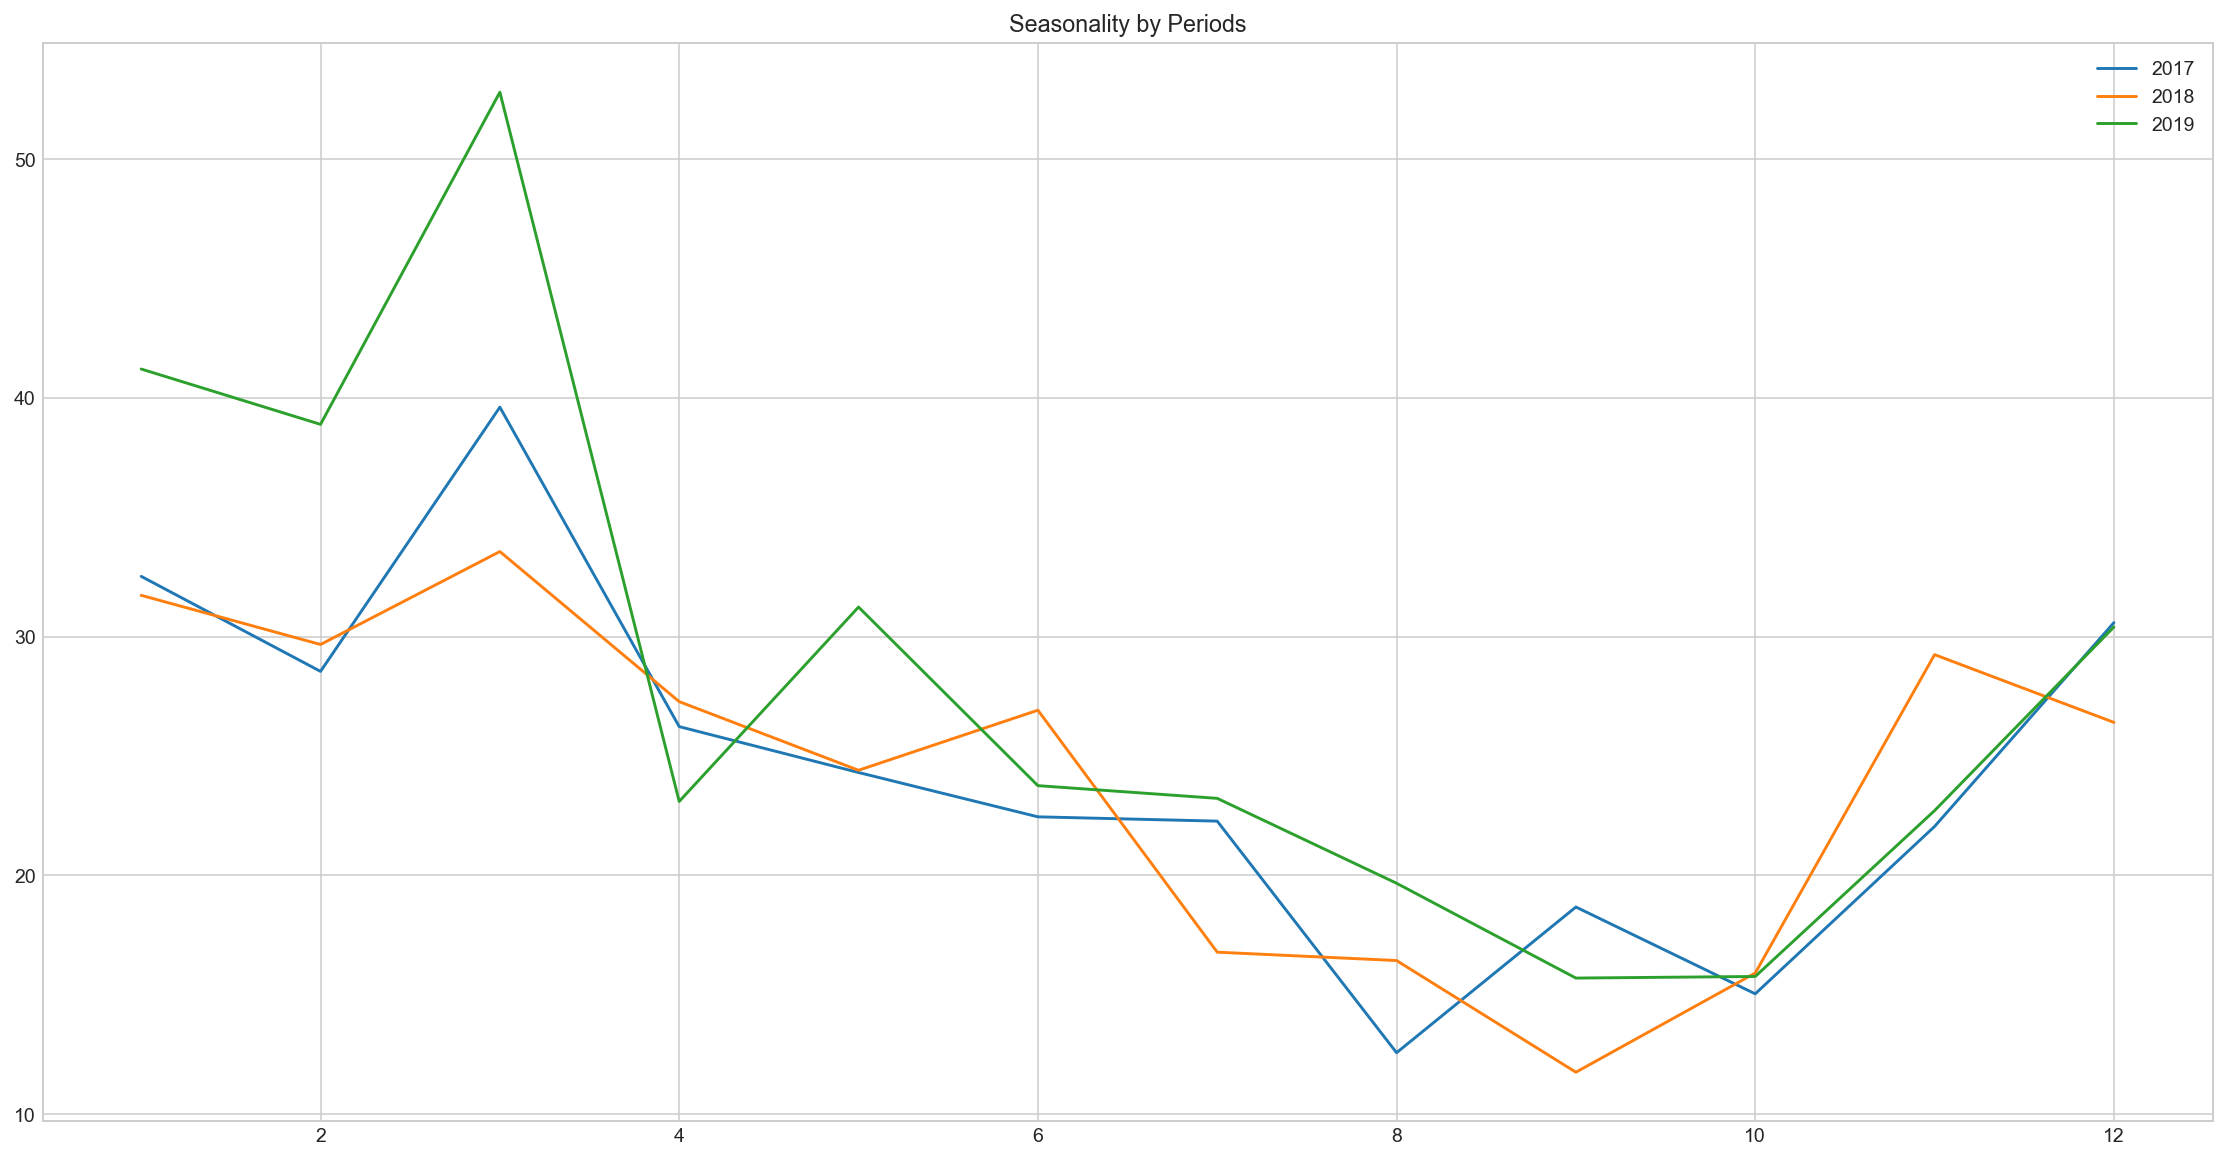

In [120]:
def seasonal_plot(data, column):
    plt.figure(figsize=(20, 10), dpi=140)
    for i, year in enumerate(data.index.year.unique()):
        plt.plot(list(range(1, len(data[data.index.year == year]) + 1)), data[data.index.year == year][column].values, label=year)
    plt.title("Seasonality by Periods")
    plt.legend(loc="best")
    plt.show()

seasonal_plot(m_SO2_summ, 'SO2')
seasonal_plot(m_NO2_summ, 'NO2')
seasonal_plot(m_O3_summ, 'O3')
seasonal_plot(m_CO_summ, 'CO')
seasonal_plot(m_PM10_summ, 'PM10')
seasonal_plot(m_PM2_5_summ, 'PM2.5')



Text(0.5, 0.98, 'Multiplicative model')

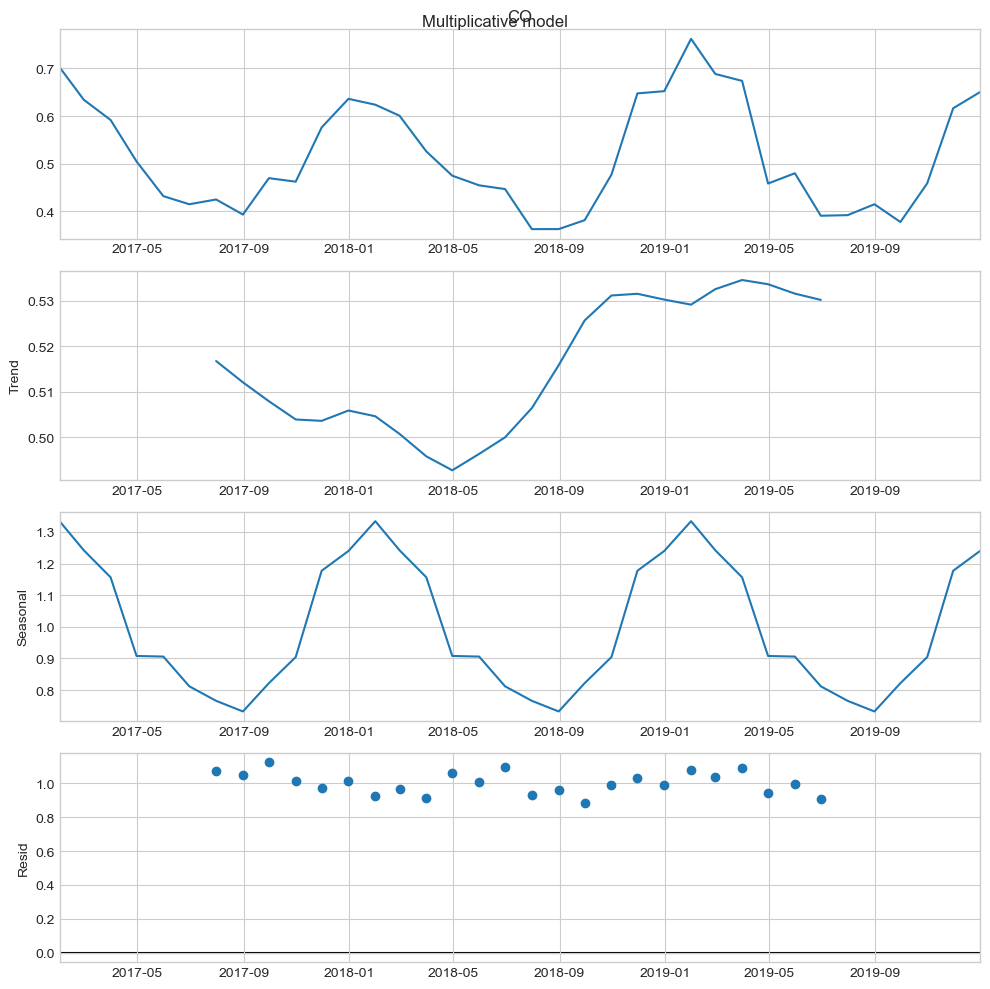

In [121]:
decomp_CO = seasonal_decompose(m_CO_summ.CO, model='multiplicative', period=12)
plt.rcParams.update({'figure.figsize': (10,10)})
decomp_CO.plot().suptitle('Multiplicative model')

In [122]:
decomp_CO.seasonal['2019']

Measurement date
2019-01-31    1.334058
2019-02-28    1.242167
2019-03-31    1.156561
2019-04-30    0.907801
2019-05-31    0.905921
2019-06-30    0.811896
2019-07-31    0.765938
2019-08-31    0.732357
2019-09-30    0.821820
2019-10-31    0.904356
2019-11-30    1.177315
2019-12-31    1.239809
Freq: M, Name: seasonal, dtype: float64

Text(0.5, 0.98, 'Multiplicative model')

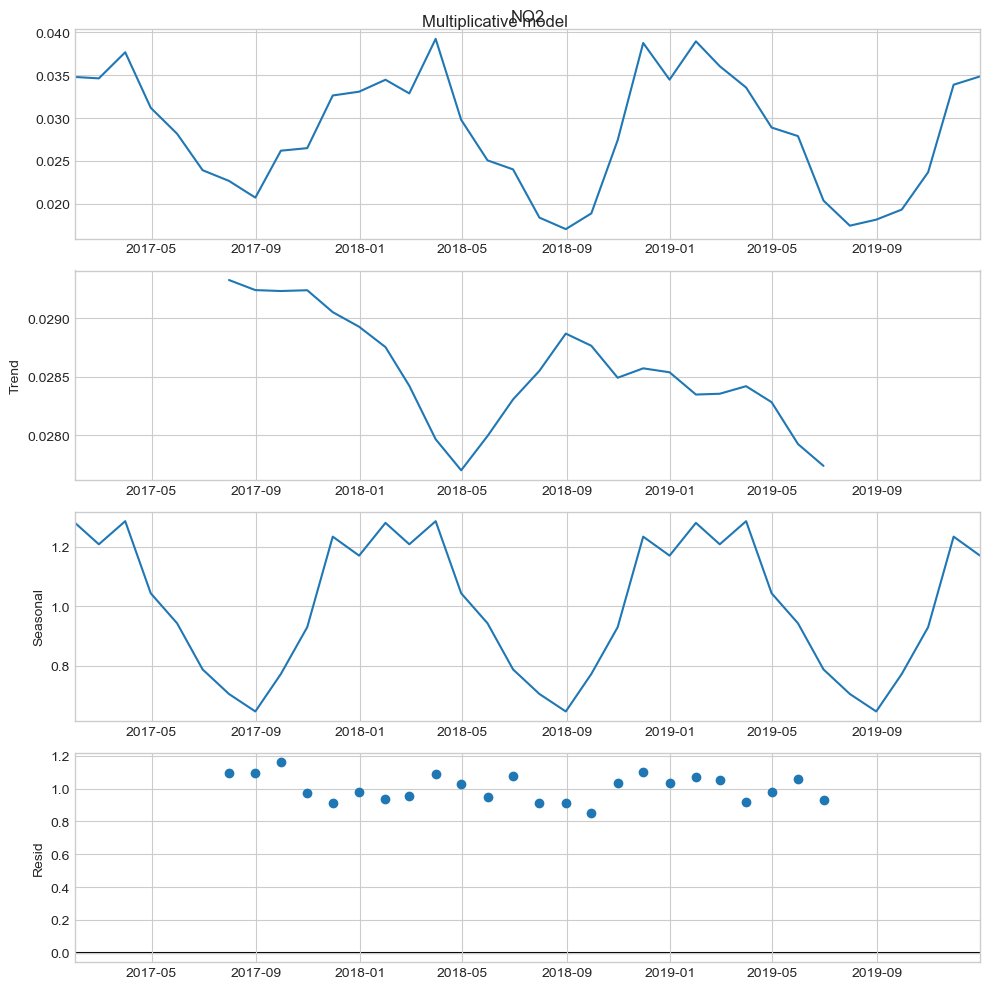

In [123]:
decom_NO2 = seasonal_decompose(m_NO2_summ.NO2, model='multiplicative', period=12)
decom_NO2.plot().suptitle('Multiplicative model')

In [124]:
decom_NO2.seasonal['2019']

Measurement date
2019-01-31    1.279610
2019-02-28    1.207629
2019-03-31    1.285302
2019-04-30    1.043099
2019-05-31    0.942205
2019-06-30    0.787226
2019-07-31    0.704719
2019-08-31    0.646034
2019-09-30    0.772010
2019-10-31    0.929244
2019-11-30    1.233309
2019-12-31    1.169612
Freq: M, Name: seasonal, dtype: float64

Text(0.5, 0.98, 'Multiplicative model')

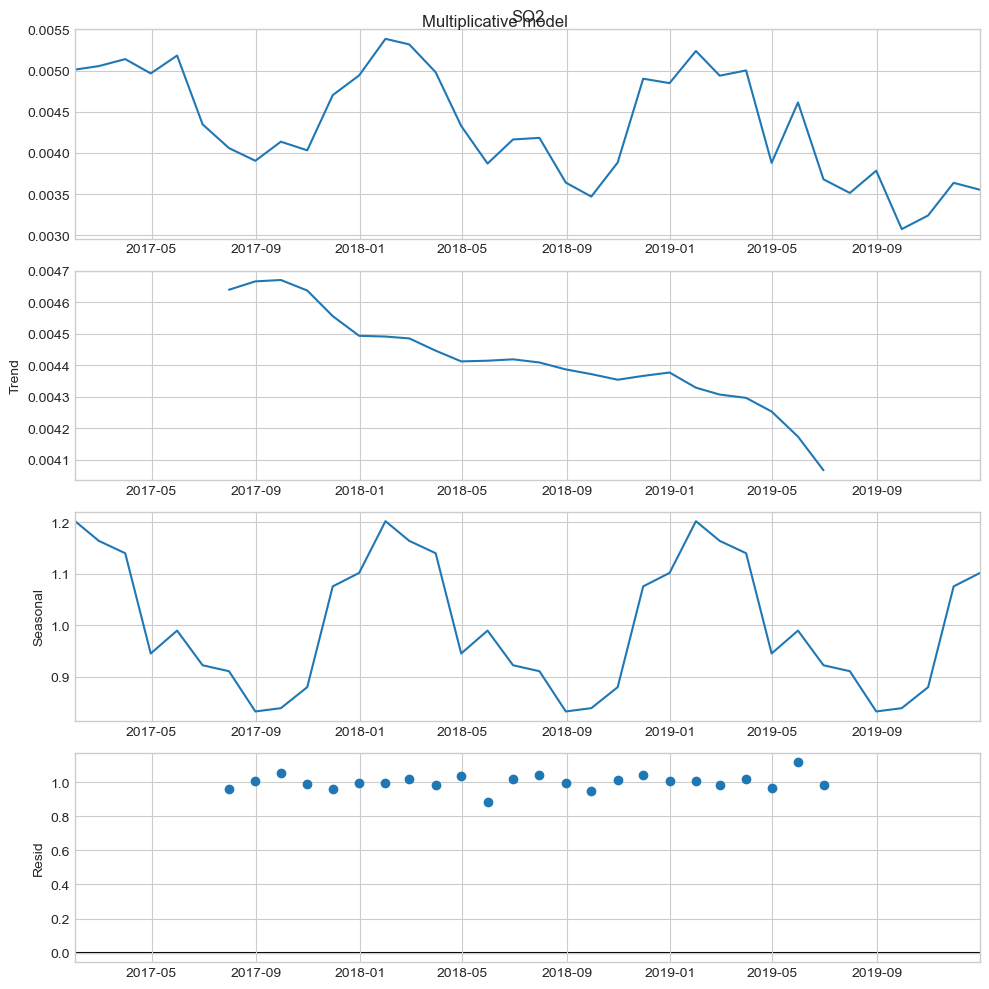

In [125]:
decom_SO2 = seasonal_decompose(m_SO2_summ.SO2, model='multiplicative', period=12)
decom_SO2.plot().suptitle('Multiplicative model')

Text(0.5, 0.98, 'Multiplicative model')

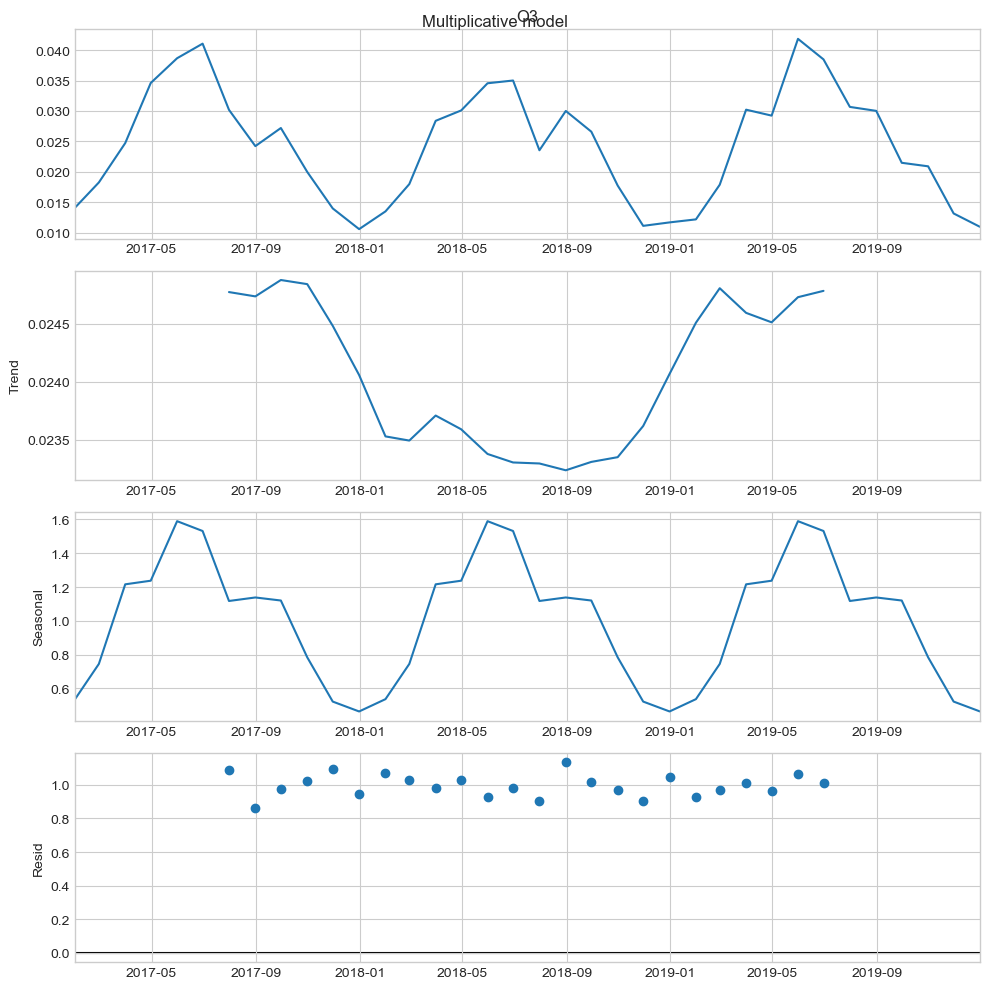

In [126]:
decom_O3 = seasonal_decompose(m_O3_summ.O3, model='multiplicative', period=12)
decom_O3.plot().suptitle('Multiplicative model')

Text(0.5, 0.98, 'Multiplicative model')

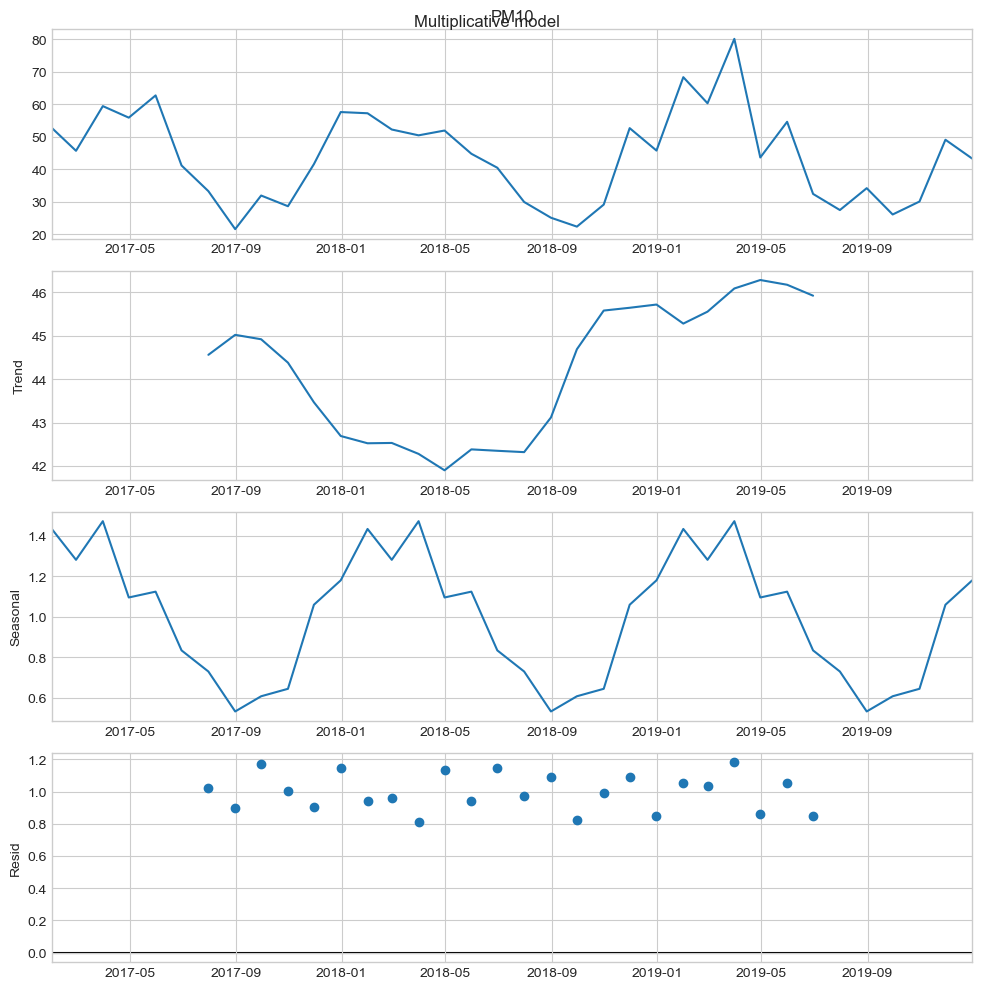

In [127]:
decom_PM10 = seasonal_decompose(m_PM10_summ.PM10, model='multiplicative', period=12)
decom_PM10.plot().suptitle('Multiplicative model')

Text(0.5, 0.98, 'Multiplicative model')

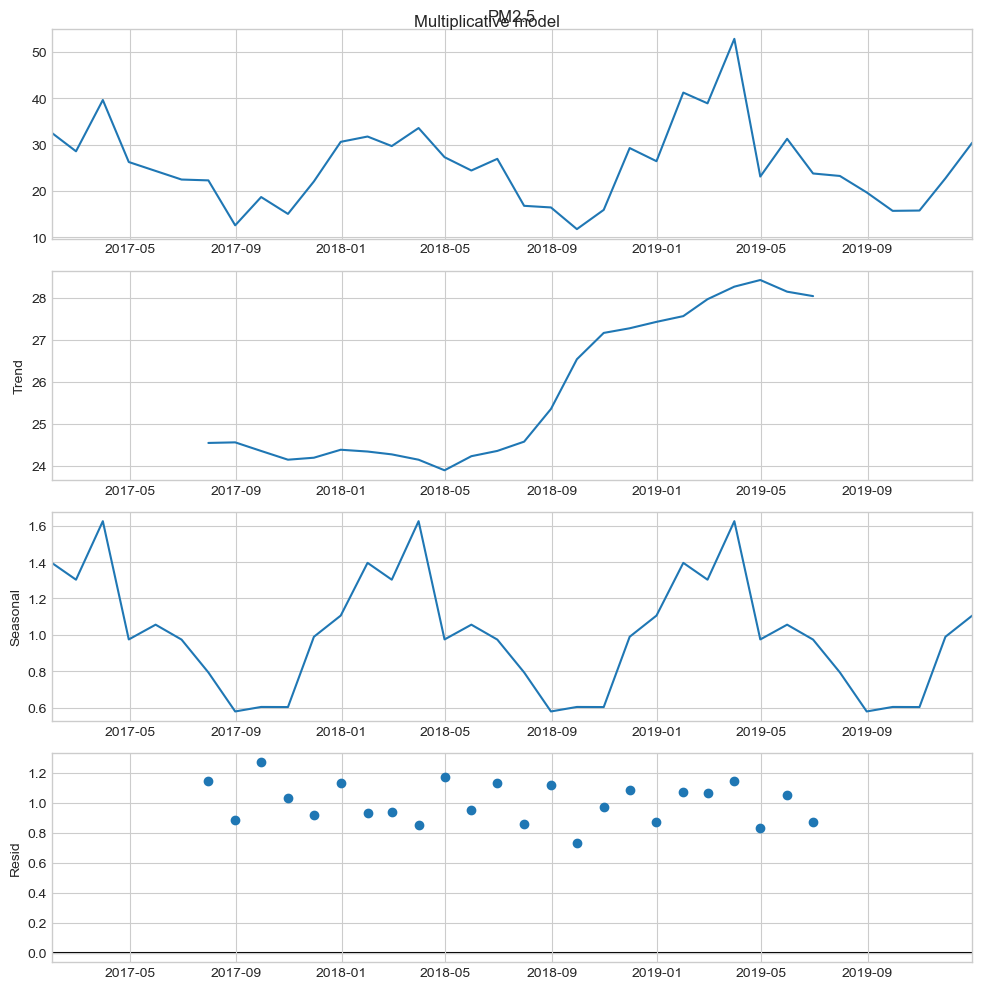

In [128]:
decom_PM2_5 = seasonal_decompose(m_PM2_5_summ['PM2.5'], model='multiplicative', period=12)
decom_PM2_5.plot().suptitle('Multiplicative model')

In [138]:
from statsmodels.tsa.ar_model import AutoReg
dftest = adfuller(m_CO_summ['CO'], autolag='AIC')
dftest

(-4.922728099062569,
 3.149060305518346e-05,
 6,
 29,
 {'1%': -3.6790595944893187,
  '5%': -2.9678817237279103,
  '10%': -2.6231583472057074},
 -66.73712604247939)

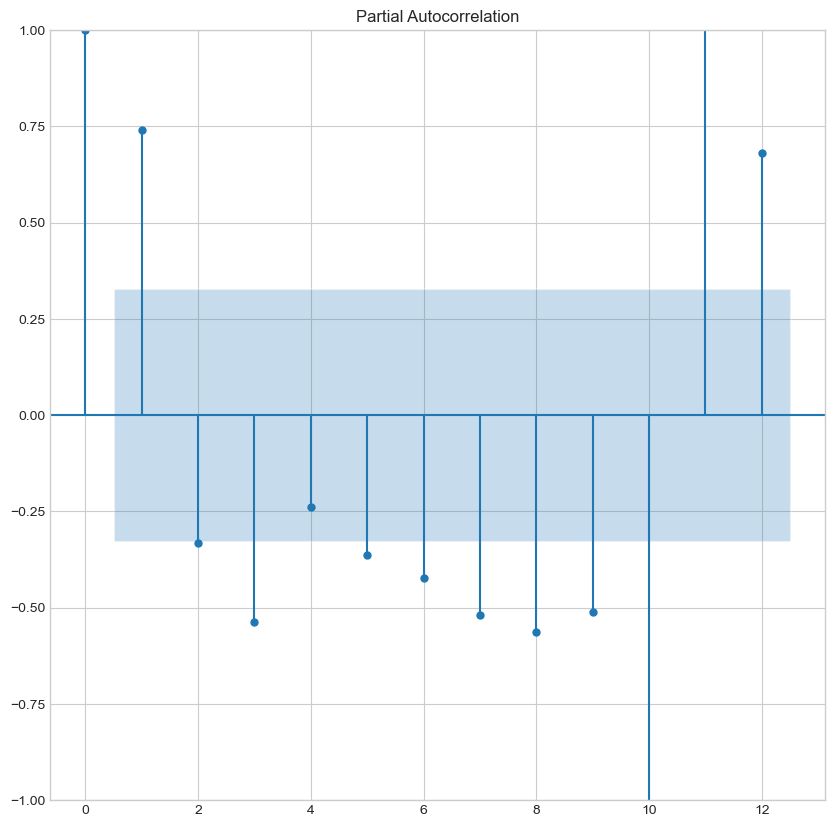

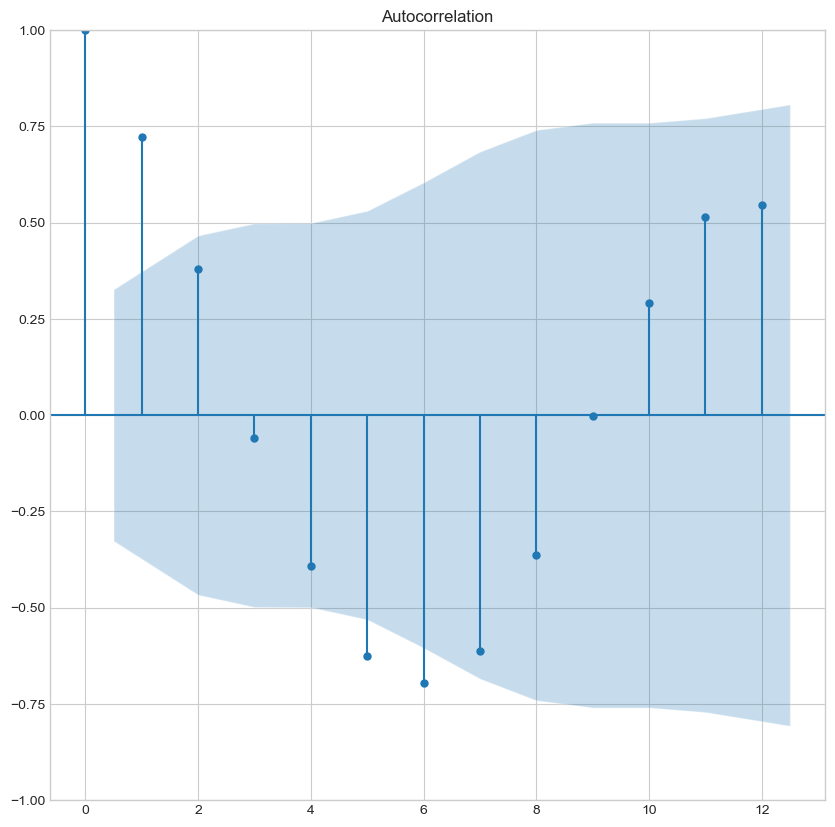

In [140]:
pacf = plot_pacf(m_CO_summ.CO, lags=12)
acf = plot_acf(m_CO_summ.CO, lags=12)

In [141]:
model = AutoReg(m_CO_summ.CO, lags=12).fit()
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                     CO   No. Observations:                   36
Model:                    AutoReg(12)   Log Likelihood                  42.235
Method:               Conditional MLE   S.D. of innovations              0.042
Date:                Fri, 30 Jun 2023   AIC                            -56.471
Time:                        17:29:44   BIC                            -39.978
Sample:                    01-31-2018   HQIC                           -52.095
                         - 12-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2778      0.327      0.849      0.396      -0.364       0.919
CO.L1          0.3656      0.196      1.862      0.063      -0.019       0.751
CO.L2          0.4009      0.238      1.686      0.0

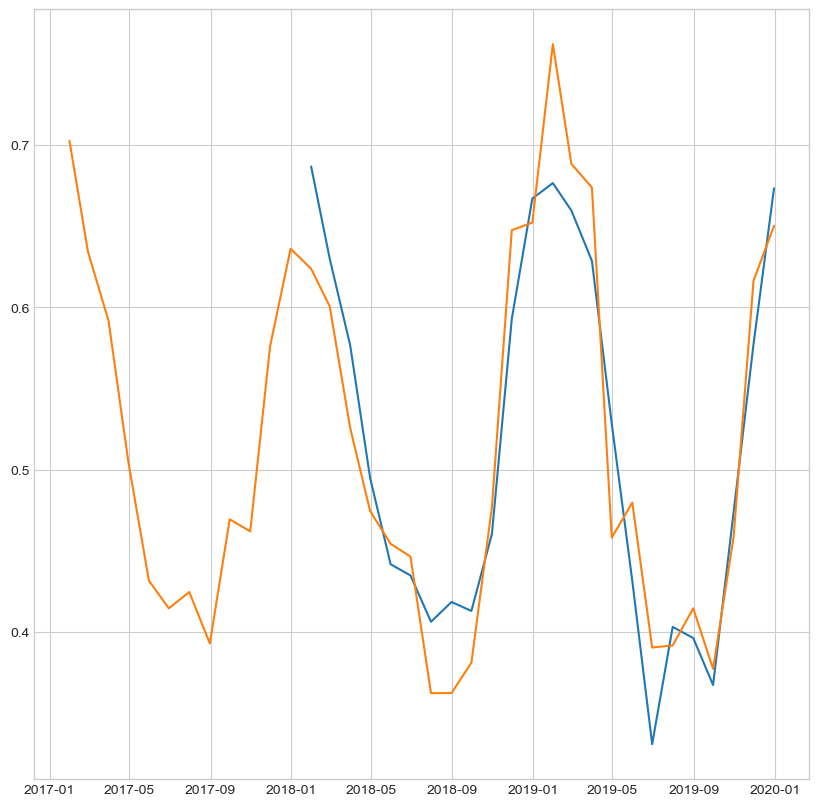

Measurement date
2017-01-31         NaN
2017-02-28         NaN
2017-03-31         NaN
2017-04-30         NaN
2017-05-31         NaN
2017-06-30         NaN
2017-07-31         NaN
2017-08-31         NaN
2017-09-30         NaN
2017-10-31         NaN
2017-11-30         NaN
2017-12-31         NaN
2018-01-31    0.686820
2018-02-28    0.630080
2018-03-31    0.576507
2018-04-30    0.494913
2018-05-31    0.441659
2018-06-30    0.434749
2018-07-31    0.406202
2018-08-31    0.418393
2018-09-30    0.412886
2018-10-31    0.460333
2018-11-30    0.592871
2018-12-31    0.667053
2019-01-31    0.676591
2019-02-28    0.659659
2019-03-31    0.628650
2019-04-30    0.528155
2019-05-31    0.431302
2019-06-30    0.330776
2019-07-31    0.403038
2019-08-31    0.396192
2019-09-30    0.367189
2019-10-31    0.473775
2019-11-30    0.577095
2019-12-31    0.673373
Freq: M, dtype: float64


In [155]:
pred = model.predict(start='2017-01-31', end='2019-12-31', dynamic=False)
plt.plot(pred)
plt.plot(m_CO_summ)
plt.show()
print(pred)

2020-01-31    0.729089
2020-02-29    0.707145
2020-03-31    0.631653
2020-04-30    0.552271
2020-05-31    0.485578
2020-06-30    0.346325
2020-07-31    0.362515
Freq: M, dtype: float64
7


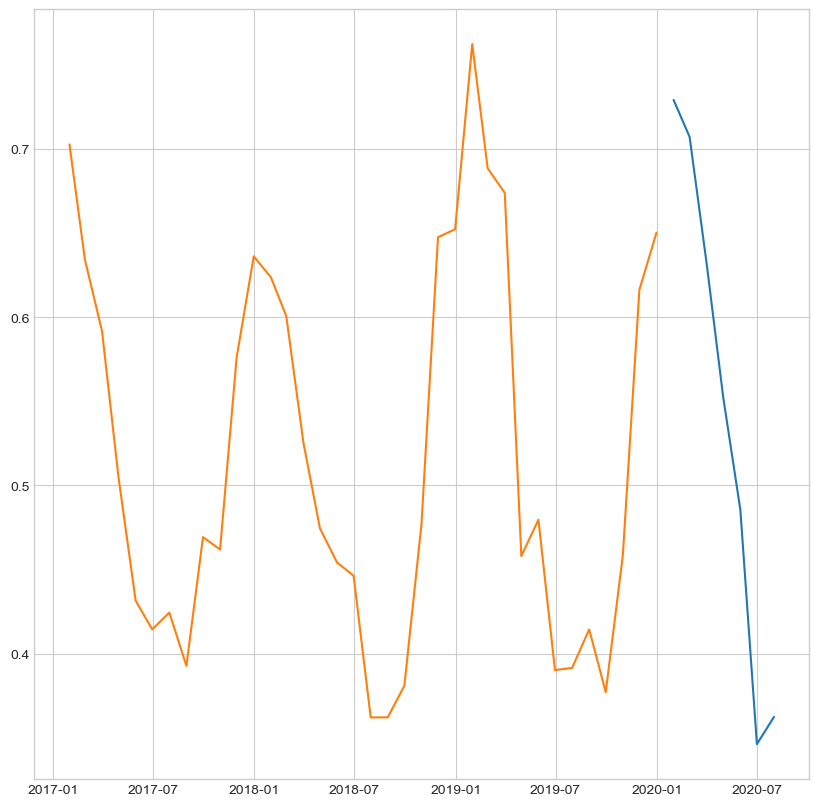

In [156]:
from matplotlib import pyplot

future_pred = model.predict(start=len(m_CO_summ), end=len(m_CO_summ)+6, dynamic=False)
pyplot.plot(future_pred)
pyplot.plot(m_CO_summ)
print(future_pred)
print(len(future_pred))

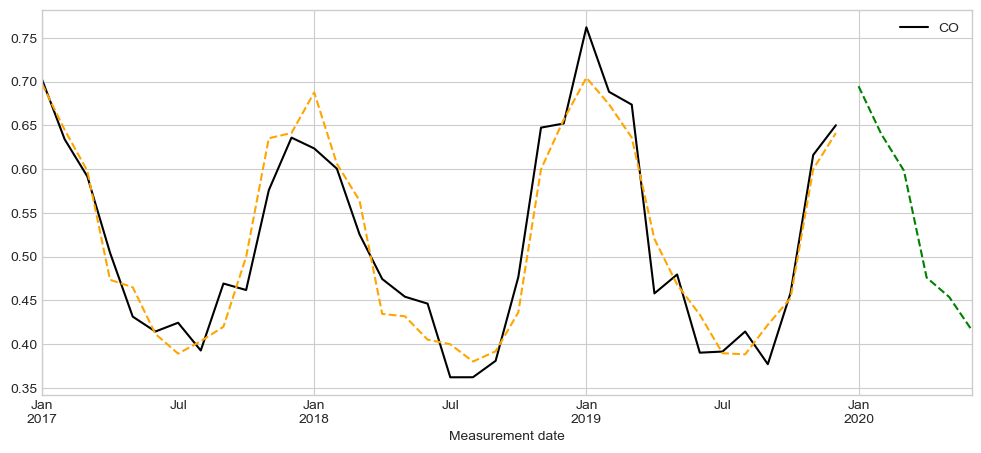

In [129]:
model_CO = ExponentialSmoothing(m_CO_summ, seasonal_periods=12, trend='add', seasonal='mul').fit()
ax = m_CO_summ.plot(figsize=(12,5), color='black')
model_CO.fittedvalues.plot(ax=ax, style='--', color='orange')
model_CO.forecast(6).plot(ax=ax, style='--', color='green')
plt.show()

•	Корреляционный анализ: есть ли связь между концентрацией SO2 и NO2? 

In [ ]:
so2 = m_summ_s.SO2
no2 = m_summ_s.NO2
correl = so2.corr(no2)
print(f"Коэфицент корреляции между SO2 and NO2: {correl}")

Коэфицент корреляции между SO2 and NO2: 0.7438982061904988


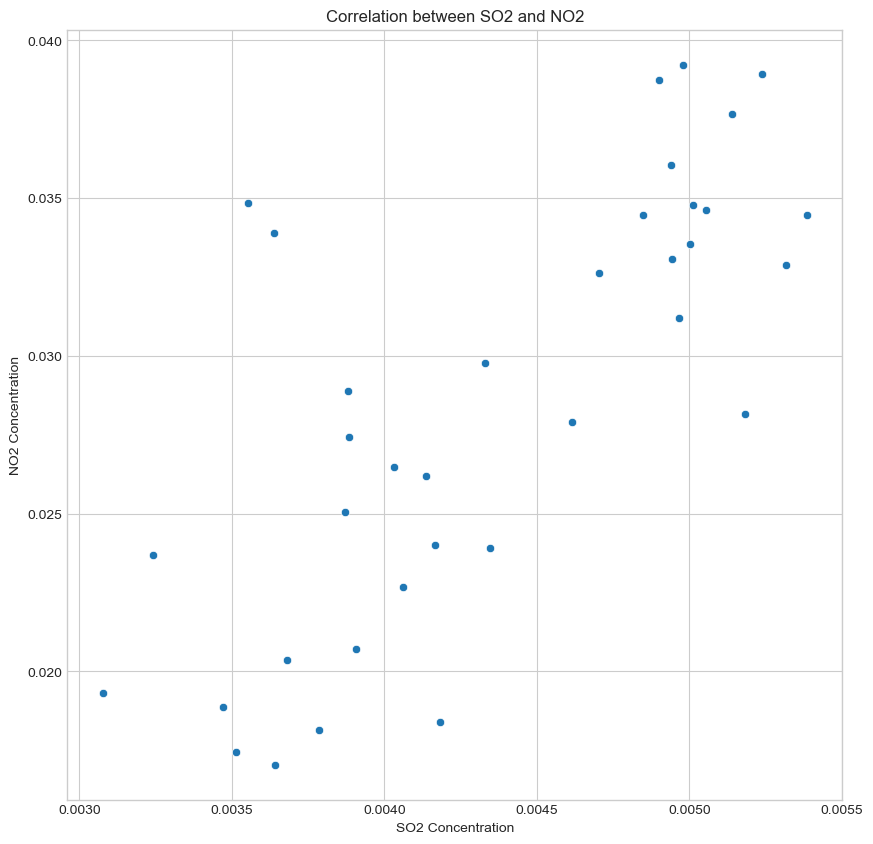

In [ ]:
sns.scatterplot(x=so2, y=no2)
plt.xlabel('SO2 Concentration')
plt.ylabel('NO2 Concentration')
plt.title('Correlation between SO2 and NO2')
plt.show()

•	Cвободный анализ 

In [ ]:
m_summ = pd.read_csv('Measurement_summary.csv')

for col in m_summ.columns[5:10]:  
    m_summ[col] = pd.to_numeric(m_summ[col], errors='coerce')  
    m_summ.loc[m_summ[col] < 0, col] = 0  

m_summ['Measurement date'] = pd.to_datetime(m_summ['Measurement date'])

df_monthly_mean = m_summ.set_index('Measurement date').resample('M')[['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']].mean()

df_station_code = m_summ.set_index('Measurement date')['Station code'].resample('M').first()

monthly_summary = pd.concat([df_station_code, df_monthly_mean], axis=1)

thresholds = {
    'SO2': [0.002, 0.005, 0.015, 0.1],
    'NO2': [0.03, 0.06, 0.2, 2.0],
    'CO': [2.0, 9.0, 15.0, 50.0],
    'O3': [0.03, 0.09, 0.15, 0.5],
    'PM10': [30.0, 80.0, 150.0, 600.0],
    'PM2.5': [15.0, 35.0, 75.0, 500.0]
}

def assign_color(value, thresholds):
    if value >= 0 and value < thresholds[1]:
        return 'blue'
    elif value < thresholds[2] and value >= thresholds[1]:
        return 'green'
    elif value < thresholds[3] and value >= thresholds[2]:
        return 'yellow'
    elif value >= thresholds[3]:
        return 'red'

for pollutant in thresholds.keys():
    threshold_values = thresholds[pollutant]
    color_column = f'{pollutant} Color'
    monthly_summary[color_column] = monthly_summary[pollutant].apply(lambda x: assign_color(x, threshold_values))


In [ ]:
elements = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

for element in elements:
    red_counts = monthly_summary[monthly_summary[f'{element} Color'] == 'red']['Station code'].value_counts()
    blue_counts = monthly_summary[monthly_summary[f'{element} Color'] == 'blue']['Station code'].value_counts()
    yellow_counts = monthly_summary[monthly_summary[f'{element} Color'] == 'yellow']['Station code'].value_counts()
    green_counts = monthly_summary[monthly_summary[f'{element} Color'] == 'green']['Station code'].value_counts()

    if not blue_counts.empty:
        station_with_most_blue = blue_counts.idxmax()
        print(f"Station code with the most blue values for {pollutant}: {station_with_most_blue}")
    else:
        print(f"No station code has blue values for {element}.")

    if not green_counts.empty:
        station_with_most_green = green_counts.idxmax()
        print(f"Station code with the most green values for {element}: {station_with_most_green}")
    else:
        print(f"No station code has green values for {element}.")

    if not yellow_counts.empty:
        station_with_most_yellow = yellow_counts.idxmax()
        print(f"Station code with the most yellow values for {element}: {station_with_most_yellow}")
    else:
        print(f"No station code has yellow values for {element}.")

    if not red_counts.empty:
        station_with_most_red = red_counts.idxmax()
        print(f"Station code with the most red values for {element}: {station_with_most_red}")
    else:
        print(f"No station code has red values for {element}.")

    print()

Station code with the most blue values for PM2.5: 101
Station code with the most green values for SO2: 101
No station code has yellow values for SO2.
No station code has red values for SO2.

Station code with the most blue values for PM2.5: 101
No station code has green values for NO2.
No station code has yellow values for NO2.
No station code has red values for NO2.

Station code with the most blue values for PM2.5: 101
No station code has green values for O3.
No station code has yellow values for O3.
No station code has red values for O3.

Station code with the most blue values for PM2.5: 101
No station code has green values for CO.
No station code has yellow values for CO.
No station code has red values for CO.

Station code with the most blue values for PM2.5: 101
Station code with the most green values for PM10: 101
No station code has yellow values for PM10.
No station code has red values for PM10.

Station code with the most blue values for PM2.5: 101
Station code with the most 

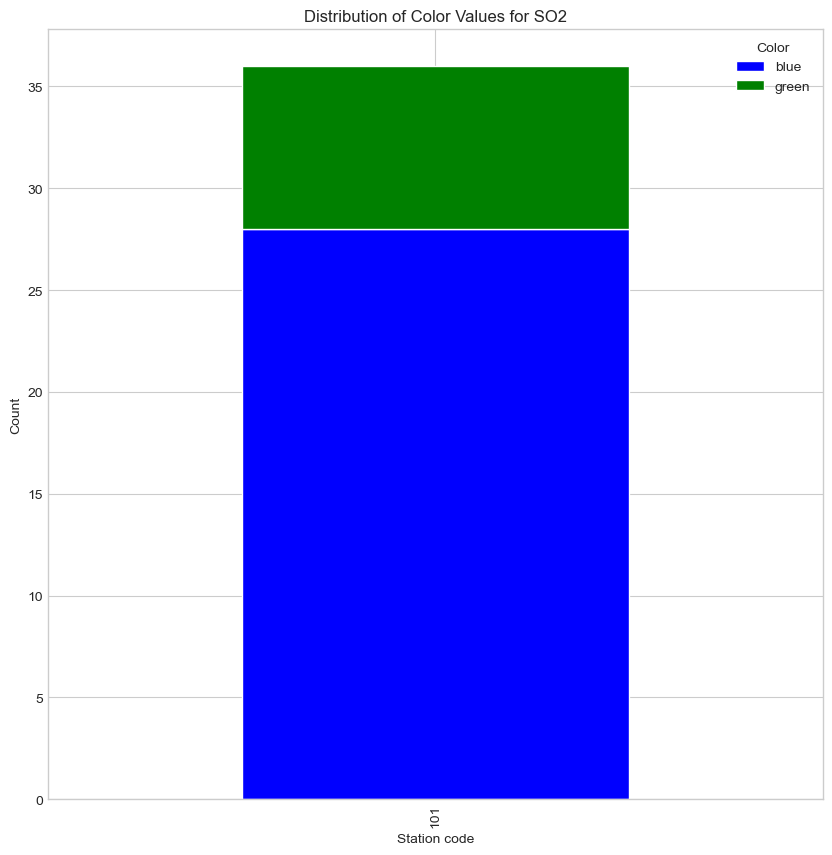

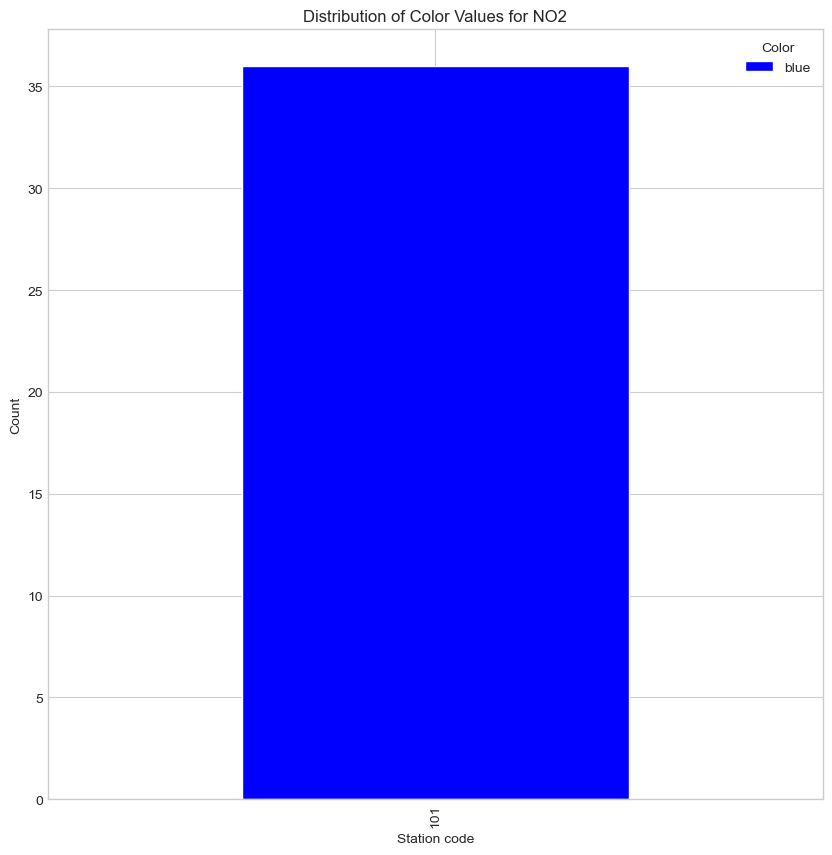

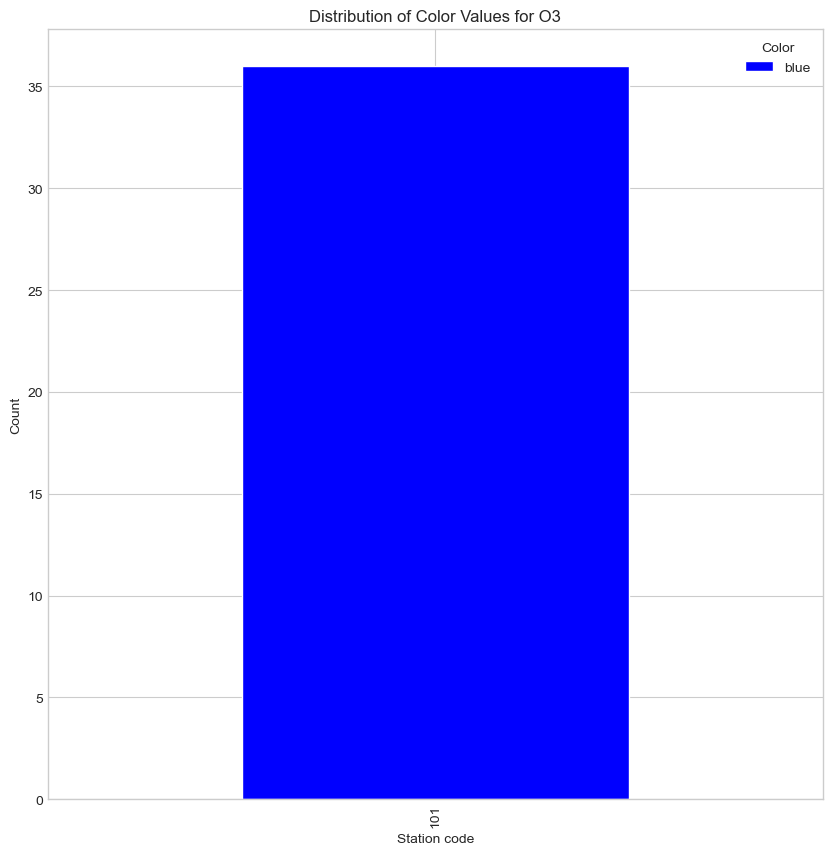

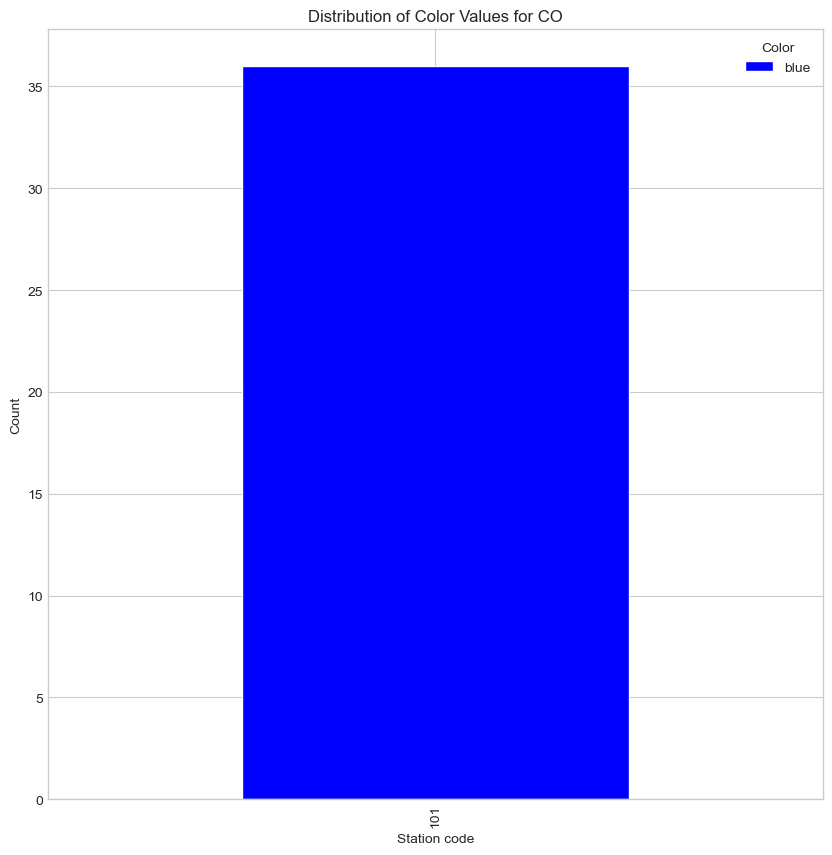

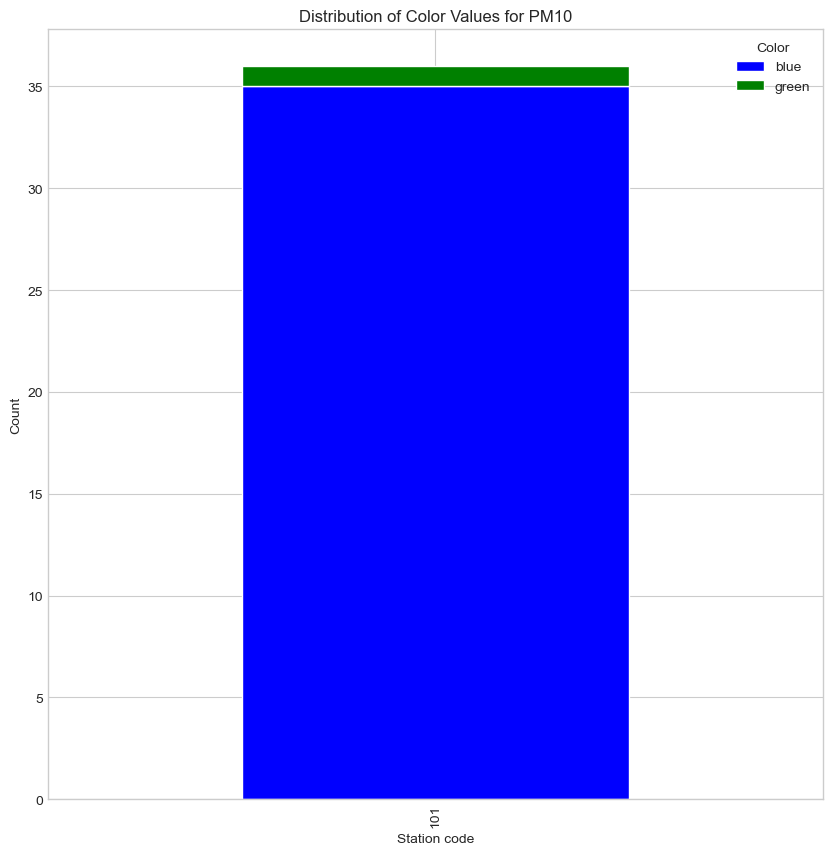

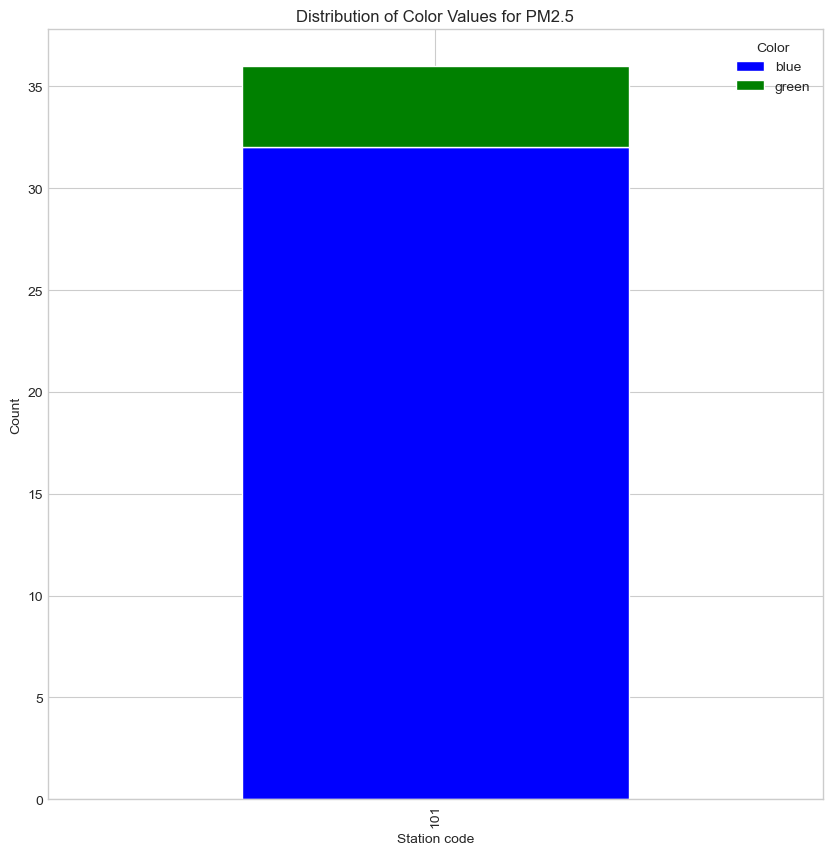

In [ ]:
color_counts = monthly_summary[['Station code', 'SO2 Color', 'NO2 Color', 'O3 Color', 'CO Color', 'PM10 Color', 'PM2.5 Color']]
color_order = ['blue', 'green', 'yellow', 'red']
for element in elements:
    # Creating a cross-tabulation of station codes and color values
    color_table = pd.crosstab(color_counts['Station code'], color_counts[f'{element} Color'])
    color_table.plot(kind='bar', stacked=True, color=color_order)
    plt.xlabel('Station code')
    plt.ylabel('Count')
    plt.title(f'Distribution of Color Values for {element}')
    plt.legend(title='Color', loc='upper right', labels=color_order)
    plt.show()